<a href="https://colab.research.google.com/github/arashms/DL-project/blob/DataPreparationForTFT/TFT-category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from pytorch_forecasting.data.examples import get_stallion_data
import pandas as pd
import torch
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor
)

from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import (
    TimeSeriesDataSet,
    GroupNormalizer
)
%config Completer.use_jedi = False

In [2]:
!ls

categorical_code	 lightning_logs  Readme		     TFT.ipynb
COVID_Regulations.ipynb  optuna_test	 TFT-category.ipynb


In [54]:
# DATA_DIR = "/content/gdrive/MyDrive/DL-proj/"
DATA_FILE = "../data.xlsx"
RANDOM_SEED = 754

MIN_PREDICTION_LENGTH = 1
MAX_PREDICTION_LENGTH = 14
MAX_ENCODER_LENGTH = 70
MIN_ENCODER_LENGTH = 1


BATCH_SIZE = 10

In [58]:
# data_embd = data.copy()
# data

time_idx      country  region  confirmed-cases  \
0             0  Afghanistan    Asia                0   
1             1  Afghanistan    Asia                0   
2             2  Afghanistan    Asia                0   
3             3  Afghanistan    Asia                0   
4             4  Afghanistan    Asia                0   
...         ...          ...     ...              ...   
74195       419     Zimbabwe  Africa               48   
74196       420     Zimbabwe  Africa               50   
74197       421     Zimbabwe  Africa               34   
74198       422     Zimbabwe  Africa               50   
74199       423     Zimbabwe  Africa               14   

       positive-Public health measures  positive-Movement restrictions  \
0                                    0                               0   
1                                    0                               0   
2                                    0                               0   
3                                    0                               0   
4                                    0                               0   
...                                ...                             ...   
74195                                0                               0   
74196                                0                               0   
74197                                0                               0   
74198                                0                               0   
74199                                0                               0   

       positive-Governance and socio-economic measures  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
74195                                                0   
74196                                                0   
74197                                                0   
74198                                                0   
74199                                                0   

       positive-Social distancing  positive-Lockdown  \
0                               0                  0   
1                               0                  0   
2                               0                  0   
3                               0                  0   
4                               0                  0   
...                           ...                ...   
74195                           0                  0   
74196                           0                  0   
74197                           0                  0   
74198                           0                  0   
74199                           0                  0   

       positive-Humanitarian exemption  ...  negative-comment-embedding10  \
0                                    0  ...                           0.0   
1                                    0  ...                           0.0   
2                                    0  ...                           0.0   
3                                    0  ...                           0.0   
4                                    0  ...                           0.0   
...                                ...  ...                           ...   
74195                                0  ...                           0.0   
74196                                0  ...                           0.0   
74197                                0  ...                           0.0   
74198                                0  ...                           0.0   
74199                                0  ...                           0.0   

       negative-comment-embedding11  negative-comment-embedding12  \
0                               0.0                           0.0   


In [57]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU available, using cuda.')
    torch.cuda.manual_seed_all(RANDOM_SEED) #for reproducablity
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

GPU available, using cuda.


In [164]:
# DATA_FILE = "../data-only-cat.xlsx"
xl_file = pd.ExcelFile(DATA_FILE)

sheets = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}

data = sheets['main']

if DATA_FILE ==  "../data-only-cat.xlsx":
    cat_fch = ['country', 'region', 'category', 'measure']
    data[cat_fch] = data[cat_fch].astype("category")
    data['comment-cluster'] = data['comment-cluster'].astype('str').astype('category')

else:
    data["country"] = data["country"].astype("category")
    data["region"] = data["region"].astype("category")


print('\n', data.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74200 entries, 0 to 74199
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   time_idx         74200 non-null  int64   
 1   country          74200 non-null  category
 2   region           74200 non-null  category
 3   confirmed-cases  74200 non-null  int64   
 4   category         74200 non-null  category
 5   measure          74200 non-null  category
 6   comment-cluster  74200 non-null  category
dtypes: category(5), int64(2)
memory usage: 1.6 MB

 None 



Text(0.5, 0, 'days')

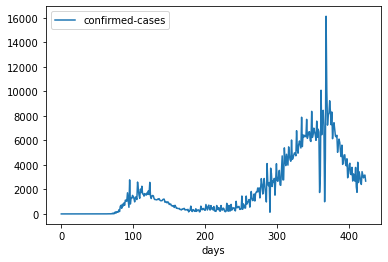

In [176]:
data[data.country=='Canada'].plot(x='time_idx', y='confirmed-cases')
plt.xlabel("days")

Text(0.5, 0, 'days')

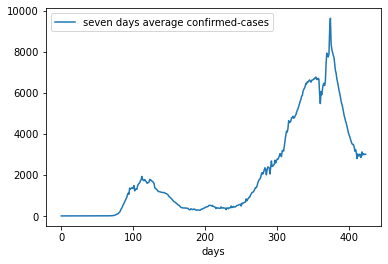

In [177]:
import matplotlib.pyplot as plt

data[data.country=='Canada']['confirmed-cases'].rolling(7).mean().fillna(0).round().astype('int').reset_index()['confirmed-cases'].plot(x='days', y='confirmed-cases')
plt.legend(['seven days average confirmed-cases'])
plt.xlabel("days")


175

In [62]:
for country in data.country.unique():
    data.loc[data.country == country, 'confirmed-cases'] =\
     data[data.country==country]['confirmed-cases'].rolling(7).\
                                                    mean().\
                                                    fillna(0).\
                                                    round().\
                                                    astype('int')

In [63]:
# Making measure comulatinve 
# Number of comulated days is sum_days

measures = [i for i in data.columns if 'comment' not in i and ("positive" in i or "negative" in i)]
sum_days = 25

for country in data.country.unique():
    data.loc[data.country == country, measures] =\
    data[data.country==country][measures].rolling(sum_days).sum().fillna(0).round().astype('int')


In [136]:
data[data.country=='Canada'].plot(x='time_idx', y=measures[0])


level_0                                                           int64
index                                                             int64
time_idx                                                          int64
country                                                        category
region                                                         category
confirmed-cases                                                   int64
positive-Public health measures                                category
positive-Movement restrictions                                 category
positive-Governance and socio-economic measures                category
positive-Social distancing                                     category
positive-Lockdown                                              category
positive-Humanitarian exemption                                category
positive-Awareness campaigns                                   category
positive-Health screenings in airports and border crossings    c

In [133]:
# Changing real values of measurements to zero and one categoris

def to_cat(x):
    
    x[x > 0] = "1"
    x[x == 0] = "0"
    
    return x


measures = [i for i in data.columns if 'comment' not in i and ("positive" in i or "negative" in i)]


data[measures] = data[measures].apply(to_cat).astype("category")



In [137]:
# Check if its working
i = 10
len(data[data[measures[i]] == "1"]) + len(data[data[measures[i]] == "0"]) == len(data)

True

Text(0.5, 1.0, 'Frequency of Countires Based on Their Continent')

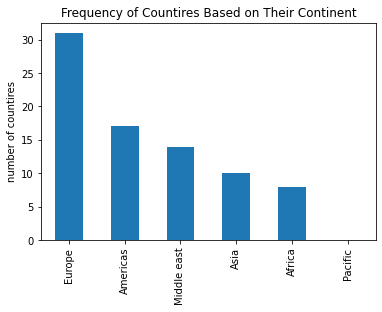

In [213]:
# len(data.country.unique())
# data.groupby(by='region').count()
# data[data.country == "Afghanistan"]
data[data.time_idx == 0]['region'].value_counts().plot(kind='bar')
plt.ylabel('number of countires')
plt.title('Frequency of Countires Based on Their Continent')

In [ ]:
!ls

In [206]:
data[(data.region == "Pacific") & (data.time_idx == 0)].count()

time_idx           0
country            0
region             0
confirmed-cases    0
category           0
measure            0
comment-cluster    0
dtype: int64

In [188]:
# Removing countires with low number of new cases
avg_threshhold = 250

deleting_countries = []

for country in data.country.unique():
    case_avg = data[data.country == country]['confirmed-cases'].mean()
    if case_avg < avg_threshhold:
        deleting_countries.append(country)
        
print(f'Deleting {len(deleting_countries)} countries from {len(data.country.unique())} countries')

for country in deleting_countries:
    
    # Deleting those countries
    indices = data[data.country == country].index
    data = data.drop(indices)

Deleting 0 countries from 80 countries


In [166]:
# Remoivng all measures
# Removing negative and positive of the comments
# In the end just combined comments will remain

not_feature = ['time_idx', 'country', 'region', 'confirmed-cases']
comments = [i for i in data.columns if 'comment' in i]
com_names = [i[9:] for i in comments]
data_only_com = data[comments].T.groupby(com_names).sum().T
data_not_feature = data[not_feature].copy()
data_not_feature[com_names[:20]] = data_only_com[com_names[:20]]
# data = data_not_feature
# data
# data_not_feature

time_idx        country    region  confirmed-cases  comment-embedding0  \
0             0      Argentina  Americas                0                 0.0   
1             1      Argentina  Americas                0                 0.0   
2             2      Argentina  Americas                0                 0.0   
3             3      Argentina  Americas                0                 0.0   
4             4      Argentina  Americas                0                 0.0   
...         ...            ...       ...              ...                 ...   
15683       419  United States  Americas            71562                 0.0   
15684       420  United States  Americas            72230                 0.0   
15685       421  United States  Americas            73376                 0.0   
15686       422  United States  Americas            68612                 0.0   
15687       423  United States  Americas            68121                 0.0   

       comment-embedding1  comment-embedding2  comment-embedding3  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
15683                 0.0                 0.0                 0.0   
15684                 0.0                 0.0                 0.0   
15685                 0.0                 0.0                 0.0   
15686                 0.0                 0.0                 0.0   
15687                 0.0                 0.0                 0.0   

       comment-embedding4  comment-embedding5  ...  comment-embedding10  \
0                     0.0                 0.0  ...                  0.0   
1                     0.0                 0.0  ...                  0.0   
2                     0.0                 0.0  ...                  0.0   
3                     0.0                 0.0  ...                  0.0   
4                     0.0                 0.0  ...                  0.0   
...                   ...                 ...  ...                  ...   
15683                 0.0                 0.0  ...                  0.0   
15684                 0.0                 0.0  ...                  0.0   
15685                 0.0                 0.0  ...                  0.0   
15686                 0.0                 0.0  ...                  0.0   
15687                 0.0                 0.0  ...                  0.0   

       comment-embedding11  comment-embedding12  comment-embedding13  \
0                      0.0                  0.0                  0.0   
1                      0.0                  0.0                  0.0   
2                      0.0                  0.0                  0.0   
3                      0.0                  0.0                  0.0   
4                      0.0                  0.0                  0.0   
...                    ...                  ...                  ...   
15683                  0.0                  0.0                  0.0   
15684                  0.0                  0.0                  0.0   
15685                  0.0                  0.0                  0.0   
15686                  0.0                  0.0                  0.0   
15687                  0.0                  0.0                  0.0   

       comment-embedding14  comment-embedding15  comment-embedding16  \
0                      0.0                  0.0                  0.0   
1                      0.0                  0.0                  0.0   
2                      0.0                  0.0                  0.0   
3                      0.0                  0.0                  0.0   
4                      0.0                  0.0                  0.0   
...    

In [70]:
comments = [i for i in data.columns if 'comment' in i]
not_feature = ['time_idx', 'country', 'region', 'confirmed-cases']

In [139]:
# data = data.reset_index()
# len(comments)
data

level_0  index  time_idx    country    region  confirmed-cases  \
0            0    848         0    Algeria    Africa                0   
1            1    849         1    Algeria    Africa                0   
2            2    850         2    Algeria    Africa                0   
3            3    851         3    Algeria    Africa                0   
4            4    852         4    Algeria    Africa                0   
...        ...    ...       ...        ...       ...              ...   
33491    33491  72499       419  Venezuela  Americas              437   
33492    33492  72500       420  Venezuela  Americas              447   
33493    33493  72501       421  Venezuela  Americas              441   
33494    33494  72502       422  Venezuela  Americas              454   
33495    33495  72503       423  Venezuela  Americas              448   

      positive-Public health measures positive-Movement restrictions  \
0                                   0                              0   
1                                   0                              0   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   
...                               ...                            ...   
33491                               0                              0   
33492                               0                              0   
33493                               0                              0   
33494                               0                              0   
33495                               0                              0   

      positive-Governance and socio-economic measures  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
33491                                               0   
33492                                               0   
33493                                               0   
33494                                               0   
33495                                               0   

      positive-Social distancing  ... negative-comment-embedding10  \
0                              0  ...                          0.0   
1                              0  ...                          0.0   
2                              0  ...                          0.0   
3                              0  ...                          0.0   
4                              0  ...                          0.0   
...                          ...  ...                          ...   
33491                          0  ...                          0.0   
33492                          0  ...                          0.0   
33493                          0  ...                          0.0   
33494                          0  ...                          0.0   
33495                          0  ...                          0.0   

      negative-comment-embedding11 negative-comment-embedding12  \
0                              0.0                          0.0   
1                              0.0                          0.0   
2                              0.0                          0.0   
3                              0.0                          0.0   
4                              0.0                          0.0   
...                            ...                          ...   
33491                          0.0                          0.0   
33492                          0.0                          0.0   
33493                          0.0                          0.0   
33494                          0.0                          0.0   
33

In [153]:
training_cutoff = data['time_idx'].max() - MAX_PREDICTION_LENGTH - 90


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='confirmed-cases',
    group_ids=['country'],
    weight=None,
    min_prediction_idx = 30,
    min_encoder_length= MIN_ENCODER_LENGTH,
    max_encoder_length = MAX_ENCODER_LENGTH,
    min_prediction_length = MIN_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    static_categoricals=['country', 'region'],
    time_varying_unknown_categoricals = measures,
    time_varying_known_reals=['time_idx'],

    time_varying_unknown_reals = comments + ['confirmed-cases'],     #
    
    target_normalizer=GroupNormalizer(
        groups=["country"], #transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(
    training, 
    data[lambda x: x.time_idx <= training_cutoff + MAX_PREDICTION_LENGTH],
    predict=True, stop_randomization=True
)


In [154]:
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE,
    num_workers=0                                     
)

val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE*10,
    num_workers=0
)

In [155]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode='min'
)

lr_logger = LearningRateMonitor()
logger = TensorBoardLogger('lightning_logs')

### Finding Optimal Learning Rate

In [225]:
pl.seed_everything(RANDOM_SEED)
trainer = pl.Trainer(
    gpus = [0],
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 754
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 1921.8k


In [40]:
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [156]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# create trainer
trainer = pl.Trainer(
    max_epochs=1000,
    gpus=[0],  # train on CPU, use gpus = [0] to run on GPU
    gradient_clip_val=0.1,
    weights_summary='top',
    limit_train_batches=30,  # running validation every 30 batches
    # fast_dev_run=True,  # comment in to quickly check for bugs
    callbacks=[lr_logger, early_stop_callback],
#     callbacks=[lr_logger],
    logger=logger,
)
# initialise model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=8e-04,
    hidden_size=16,  # biggest influence network size
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # QuantileLoss has 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # log example every 10 batches
    reduce_on_plateau_patience=4,  # reduce learning automatically
)
# tft.size() # 29.6k parameters in model
# # # fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.4 K 
3  | prescalers                         | ModuleDict                      | 736   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 38.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | Ga

/home/m25dehgh/anaconda3/envs/pyforecast/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [ ]:
!ls

In [157]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# best_tft

# trainer.fit(
#     best_tft,
#     train_dataloader=train_dataloader,
#     val_dataloaders=val_dataloader
# )
# type(best_tft)

In [158]:
data_val = data.copy()

In [159]:

avg_threshhold = 1350

deleting_countries = []

for country in data_val.country.unique():
    case_avg = data_val[data_val.country == country]['confirmed-cases'].mean()
    if case_avg < avg_threshhold:
        deleting_countries.append(country)
        
print(f'Deleting {len(deleting_countries)} countries from {len(data_val.country.unique())} countries')

for country in deleting_countries:
    
    # Deleting those countries
    indices = data_val[data_val.country == country].index
    data_val = data_val.drop(indices)

Deleting 49 countries from 79 countries


In [160]:
len(data_val.country.unique())

30

In [161]:

validation = TimeSeriesDataSet.from_dataset(
    training, 
    data[lambda x: x.time_idx <= training_cutoff + MAX_PREDICTION_LENGTH],
    predict=True, stop_randomization=True
)

val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE*10,
    num_workers=0
)

In [162]:
from pytorch_forecasting.metrics import MAPE

metric = MAPE()

# best_tft = tft
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
# (actuals - predictions).abs().mean()
metric.loss(predictions, actuals).mean()

tensor(0.6327)

In [163]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)


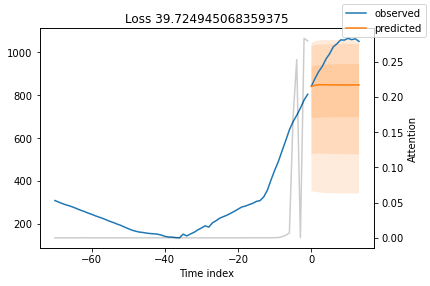

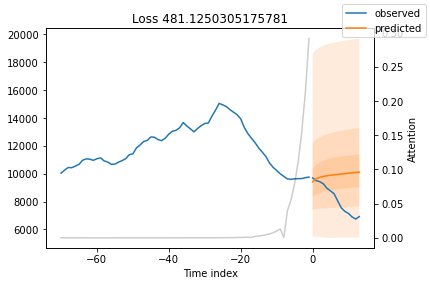

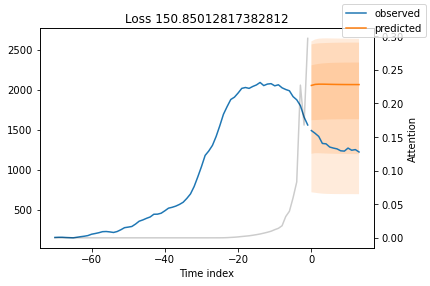

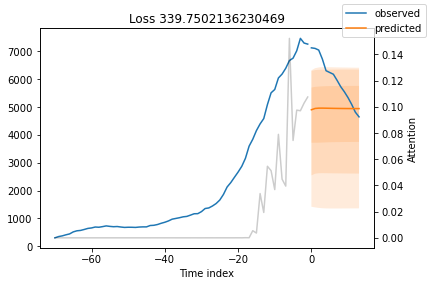

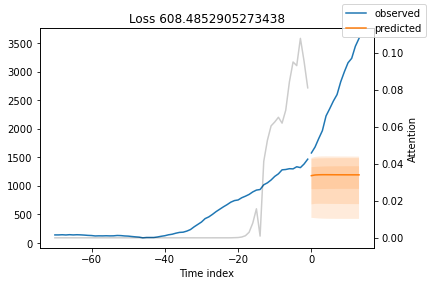

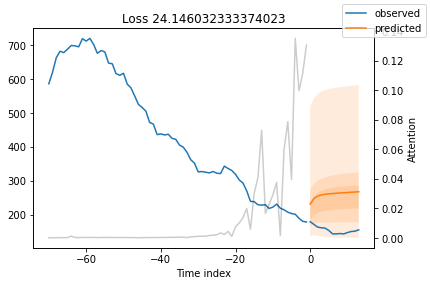

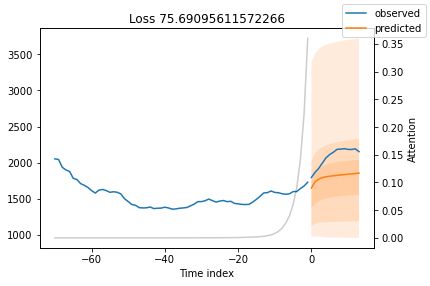

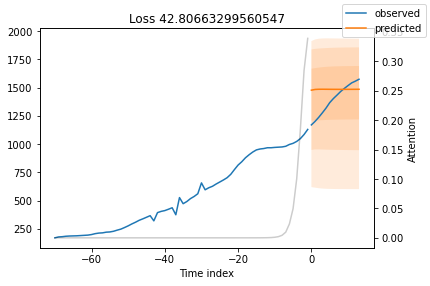

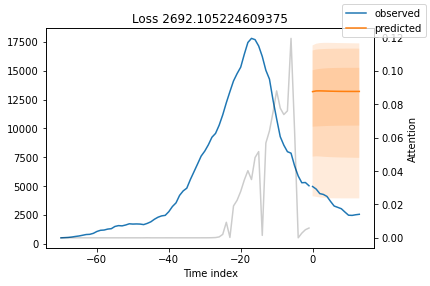

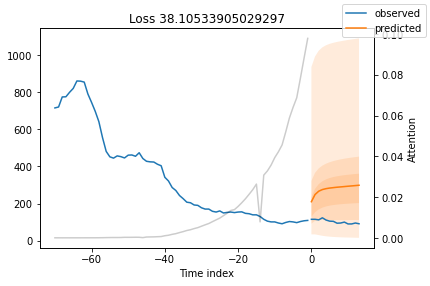

In [151]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/home/m25dehgh/anaconda3/envs/pyforecast/lib/python3.8/site-packages/pytorch_forecasting/models/base_model.py:1370: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)


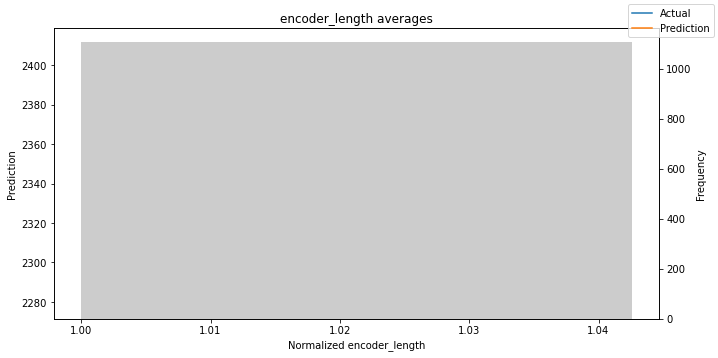

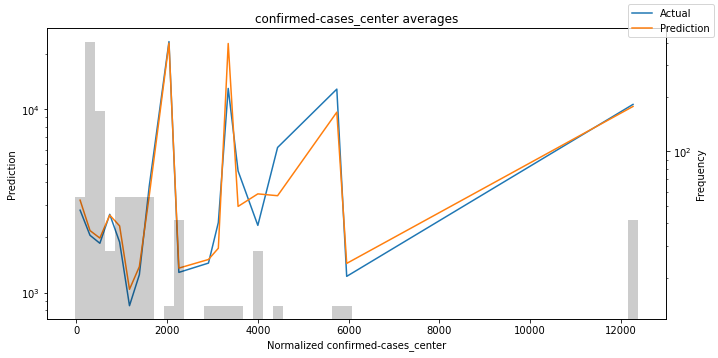

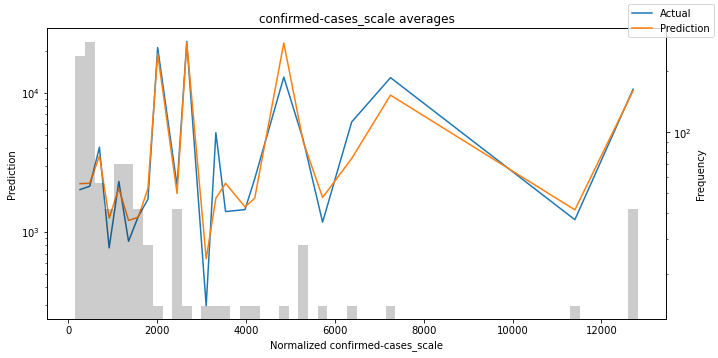

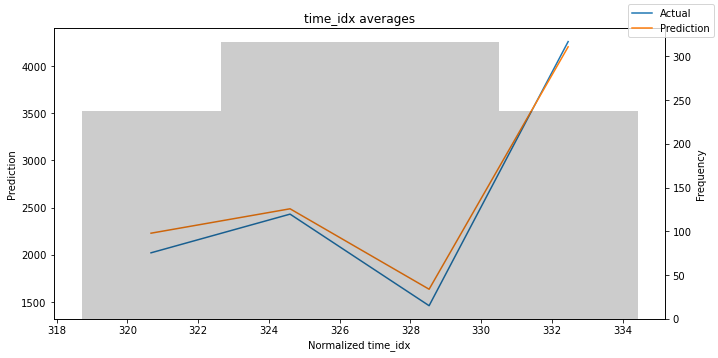

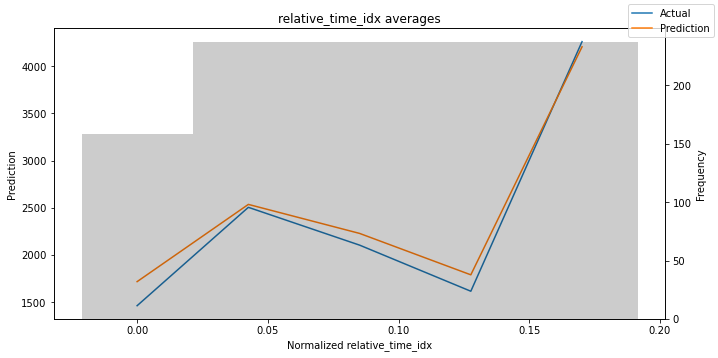

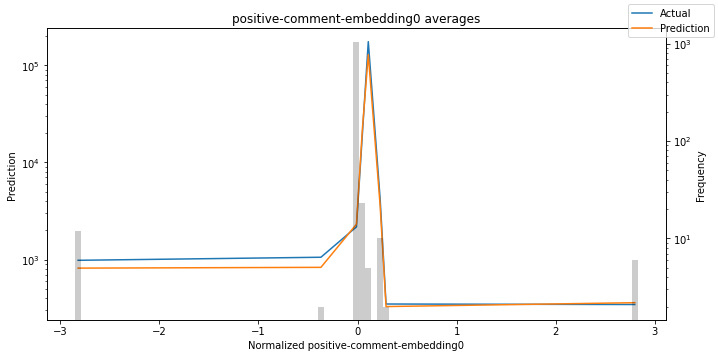

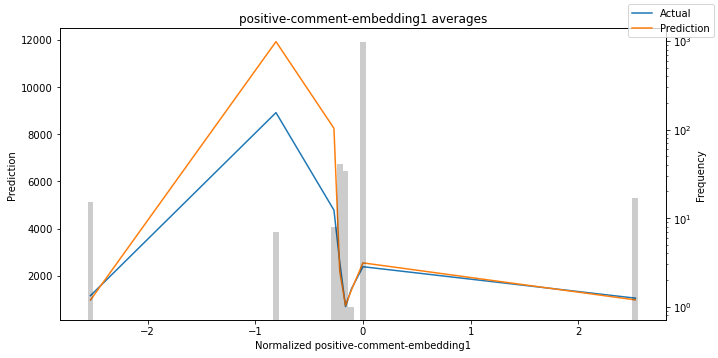

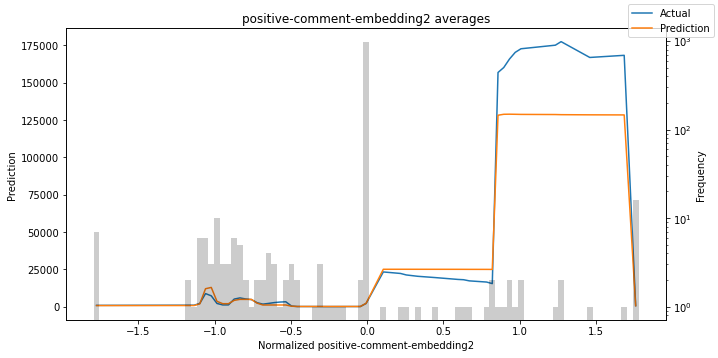

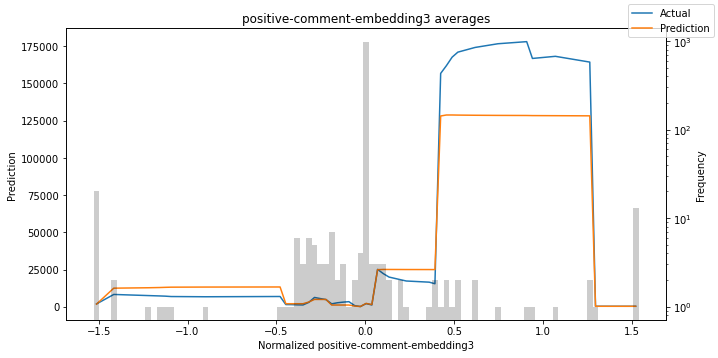

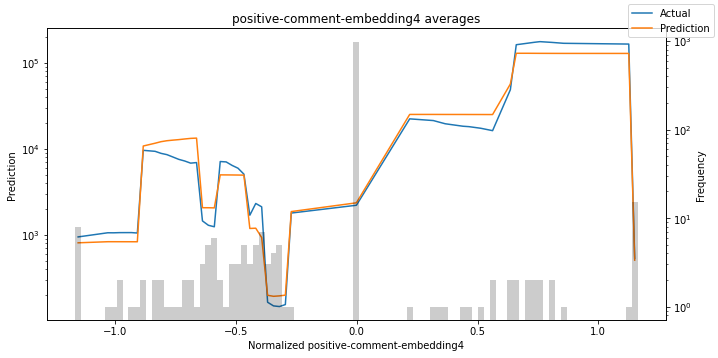

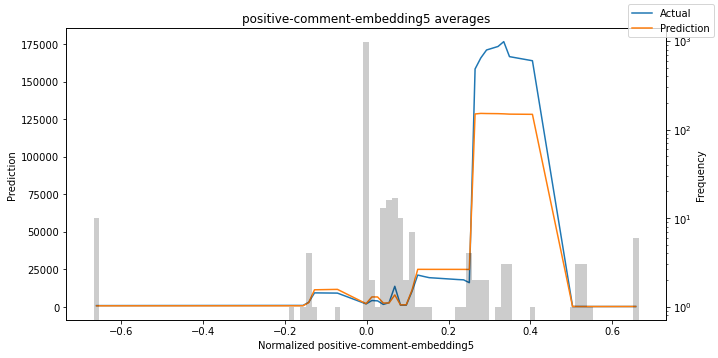

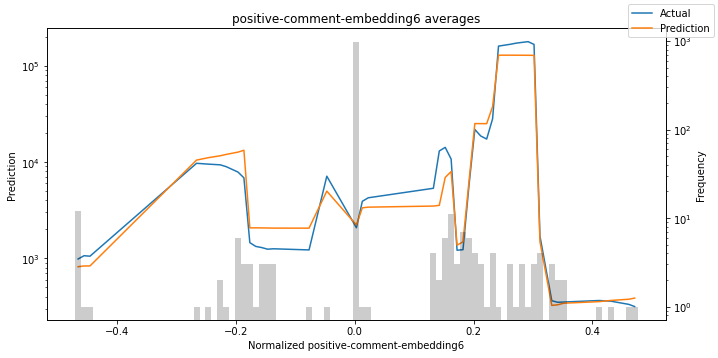

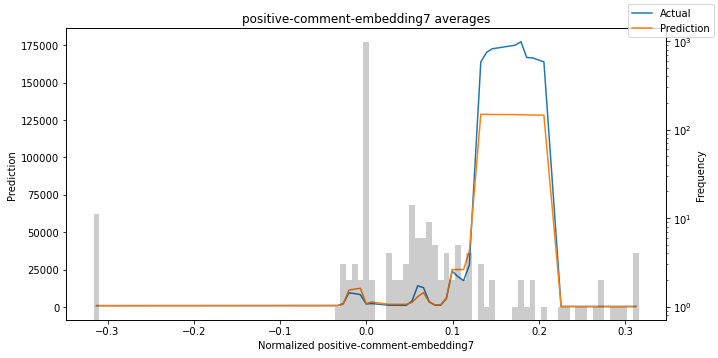

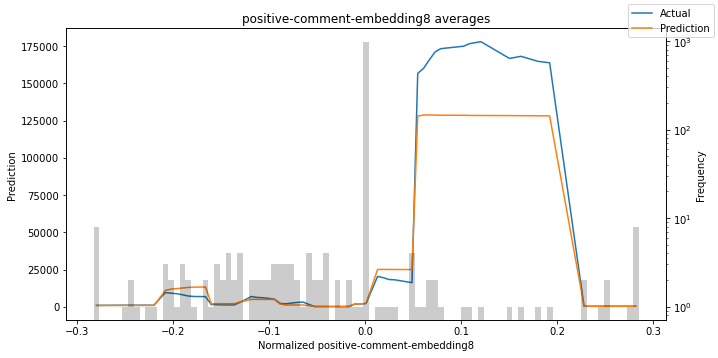

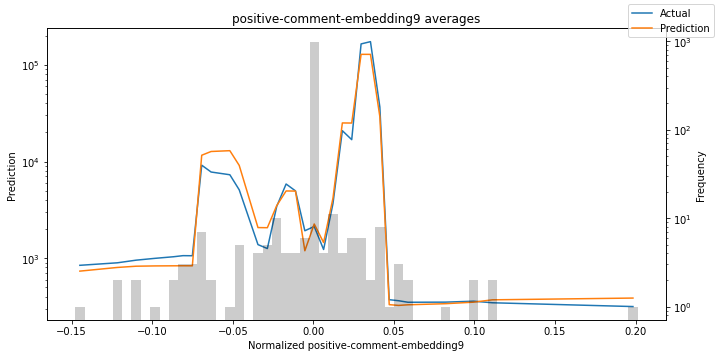

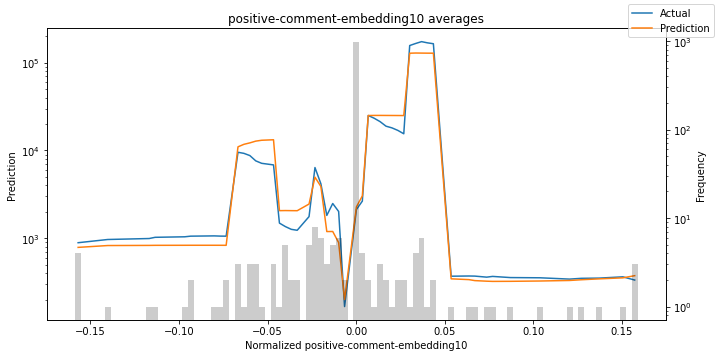

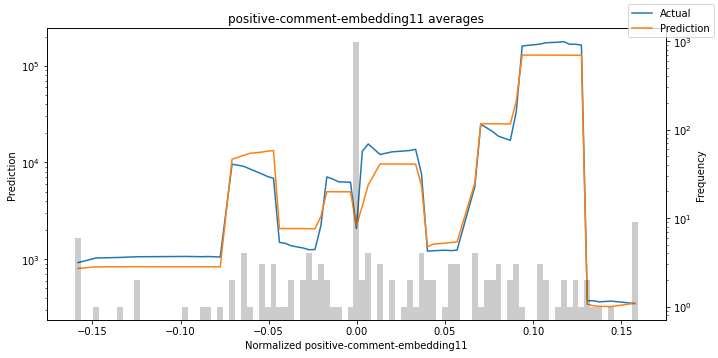

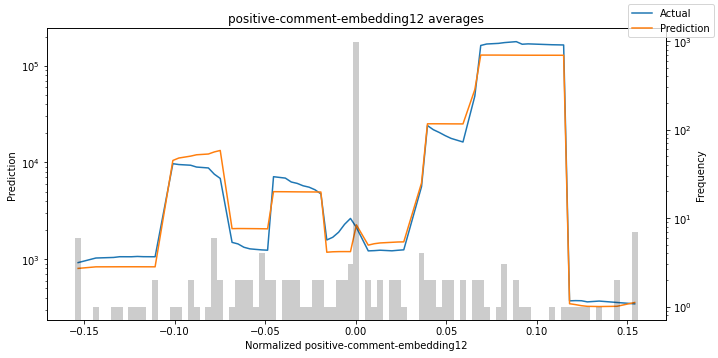

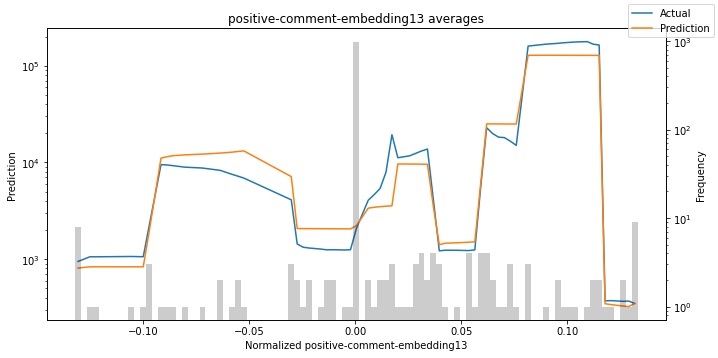

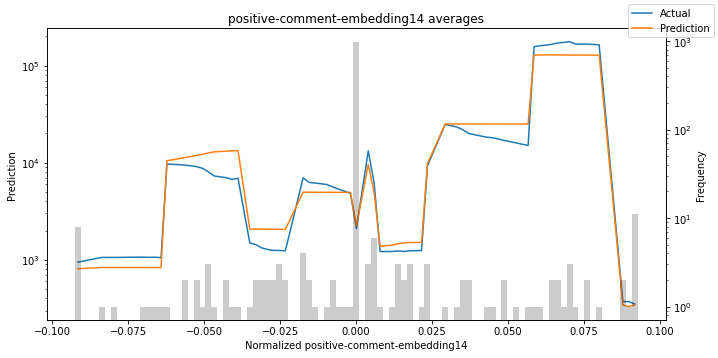

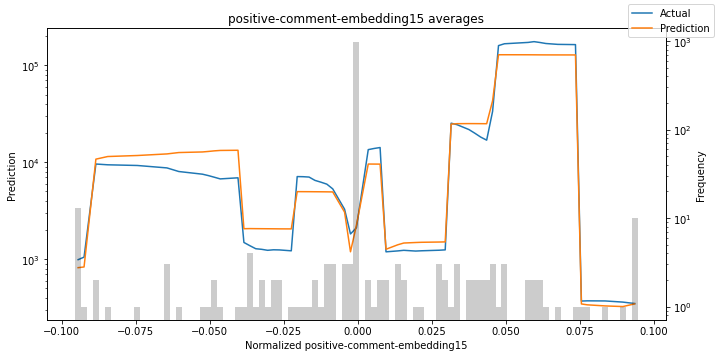

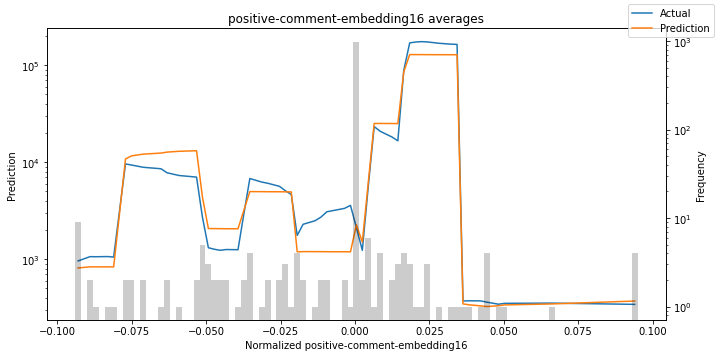

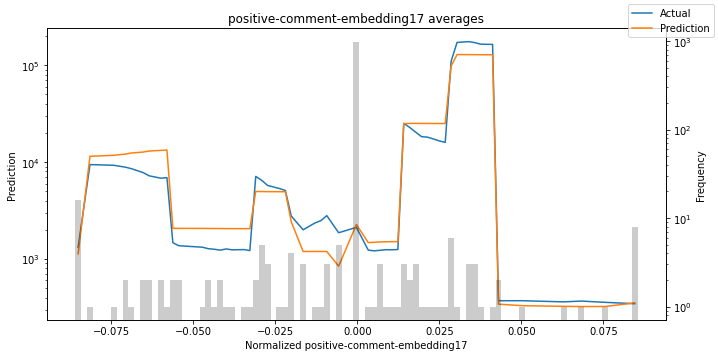

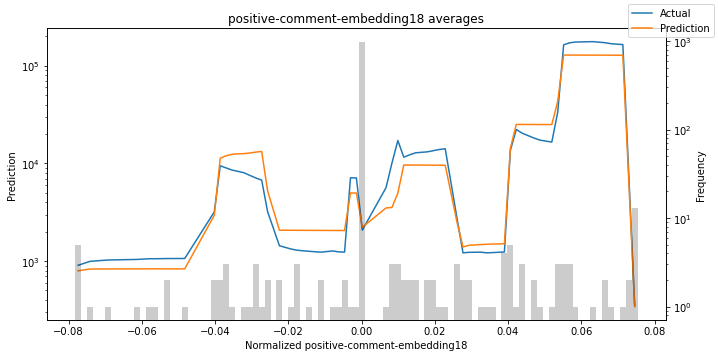

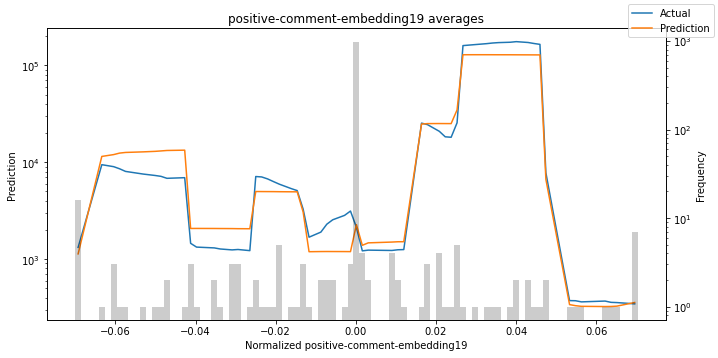

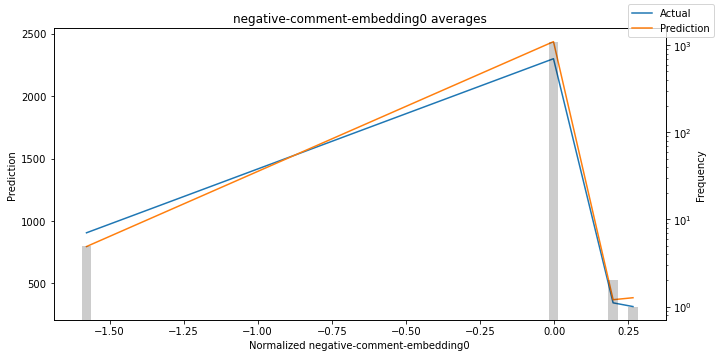

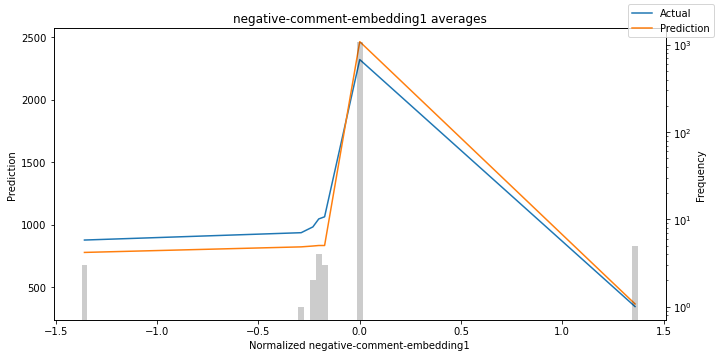

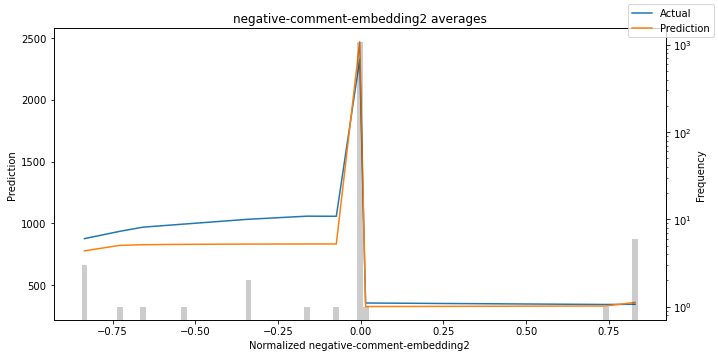

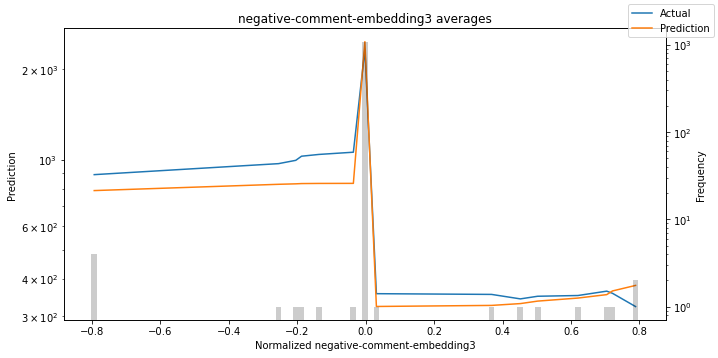

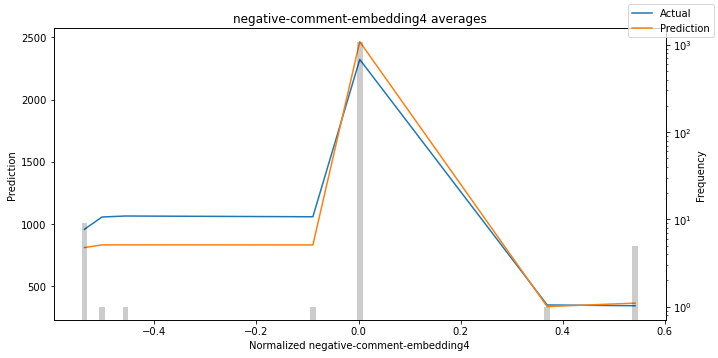

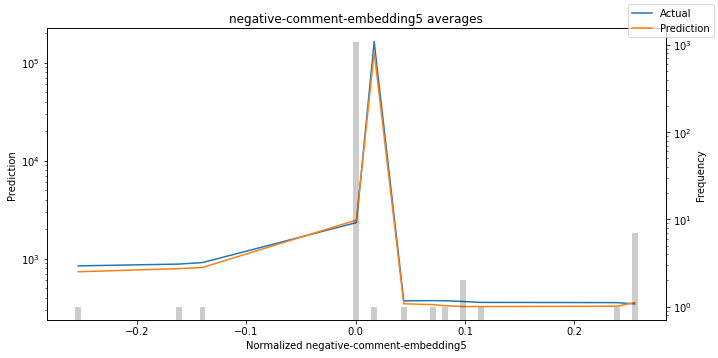

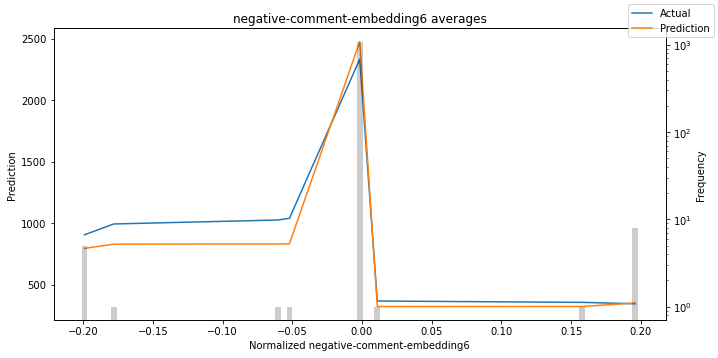

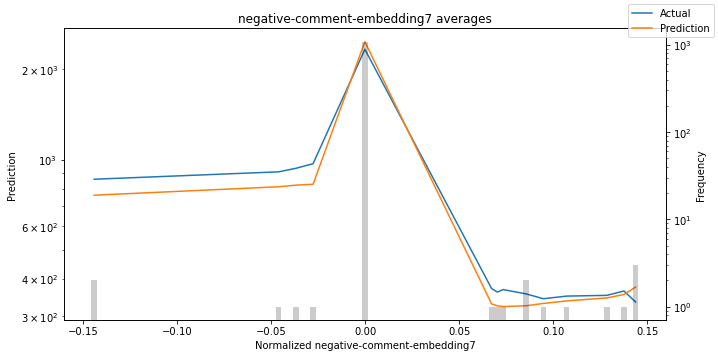

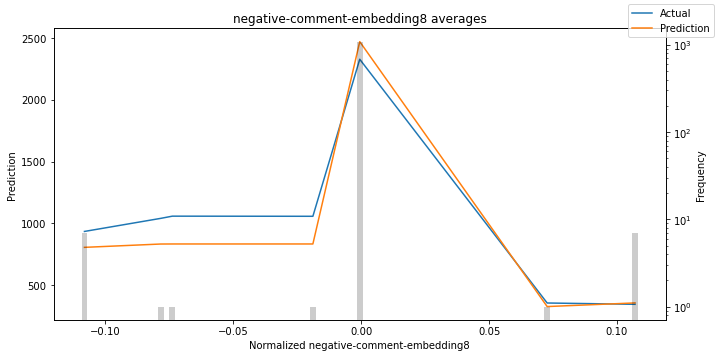

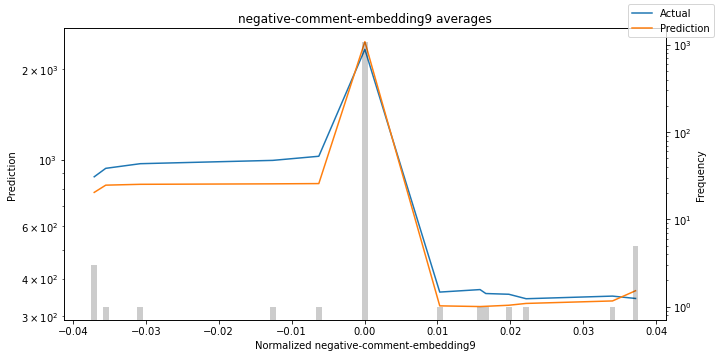

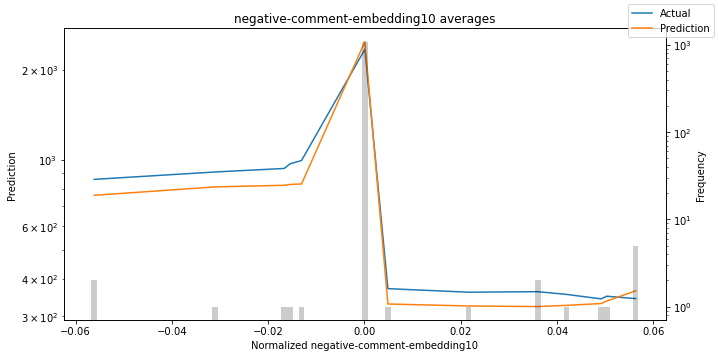

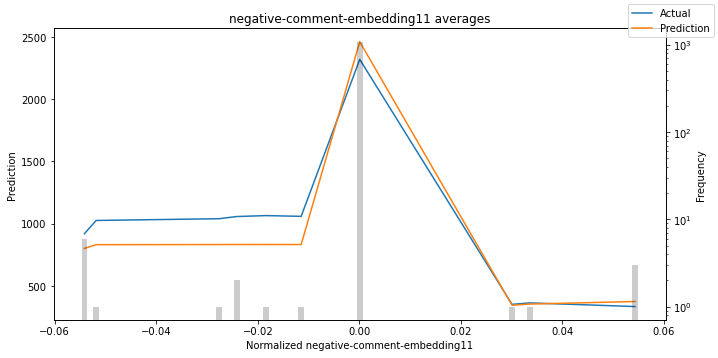

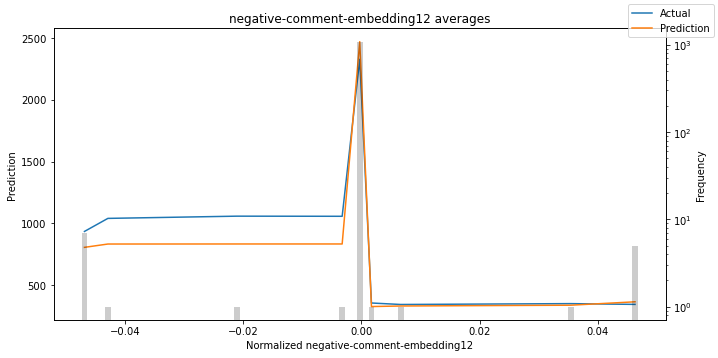

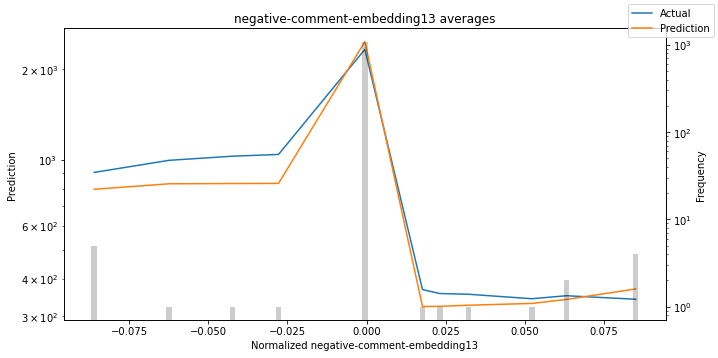

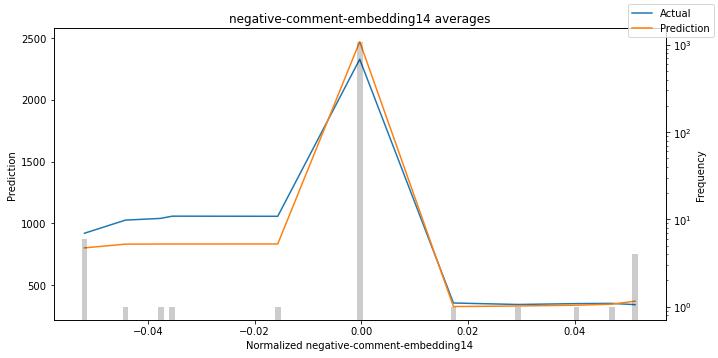

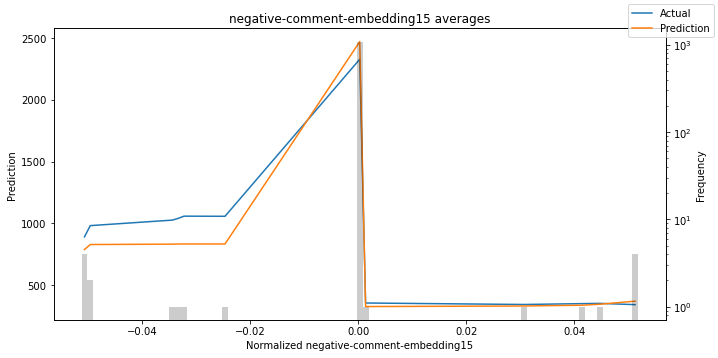

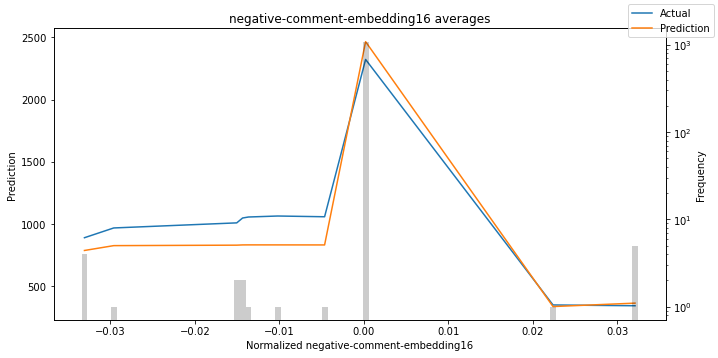

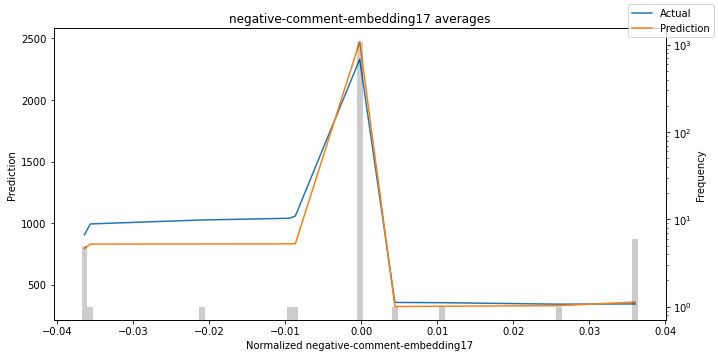

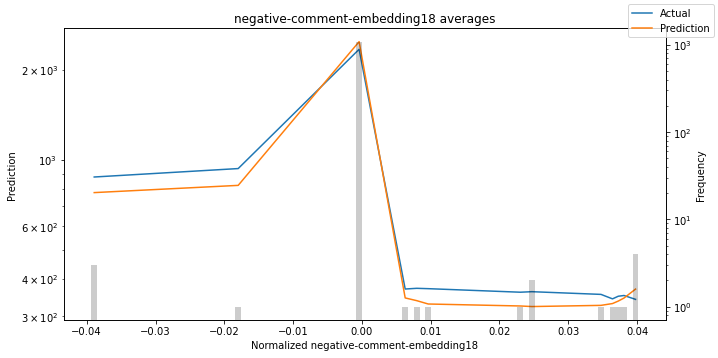

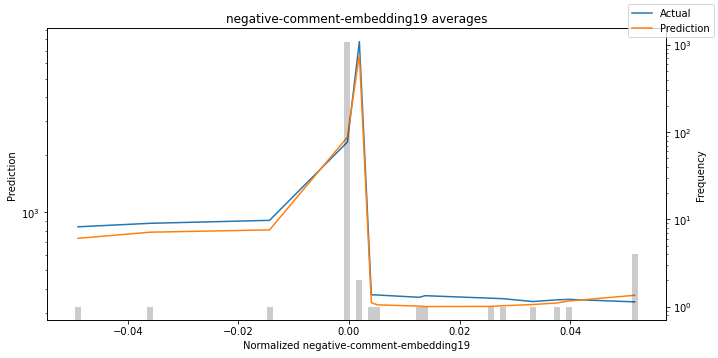

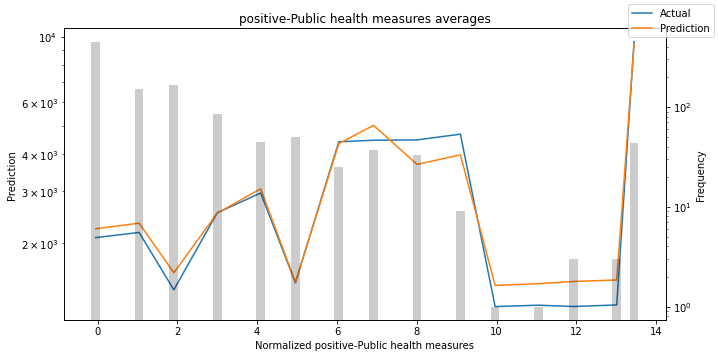

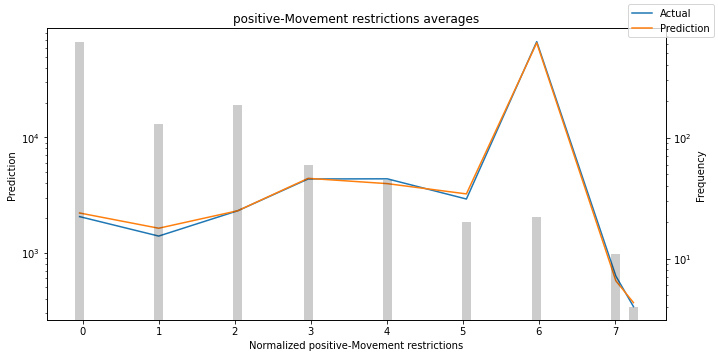

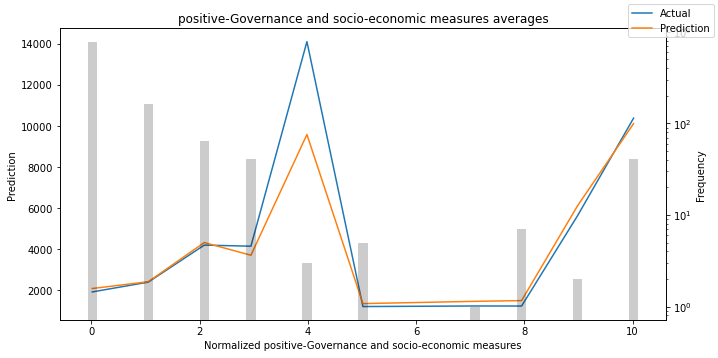

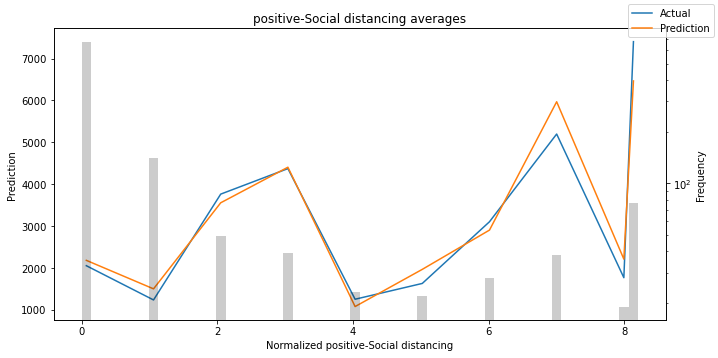

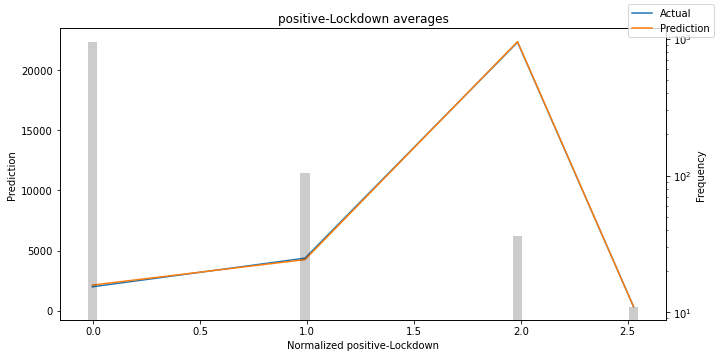

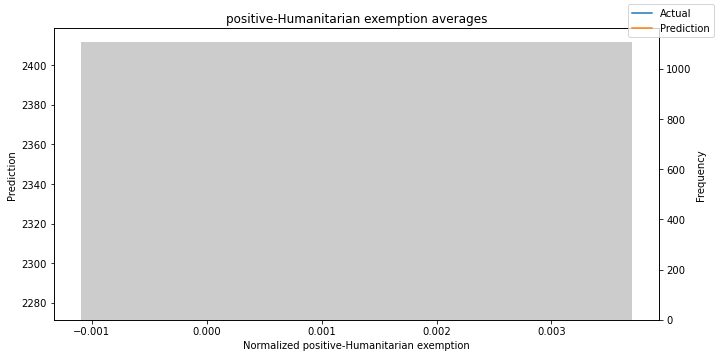

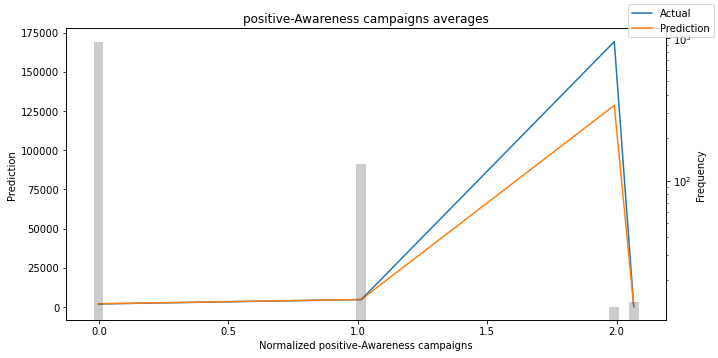

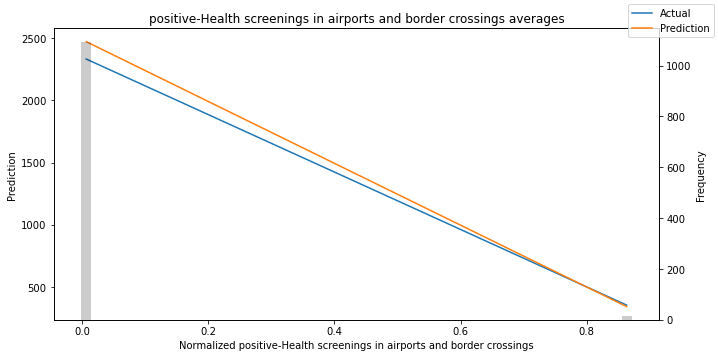

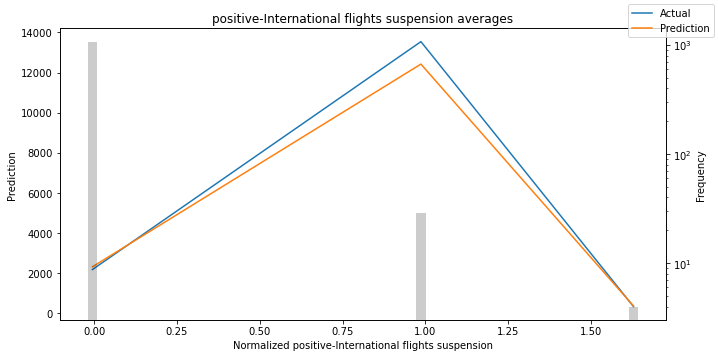

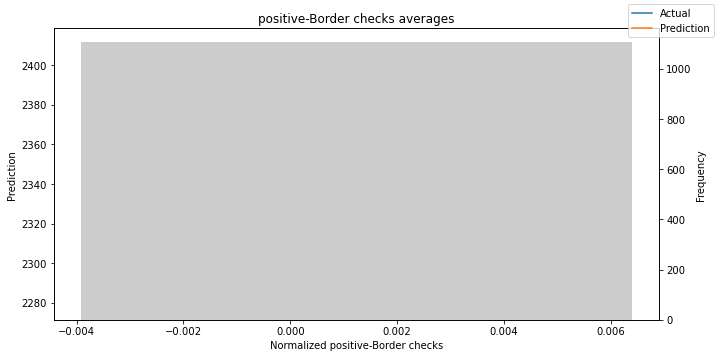

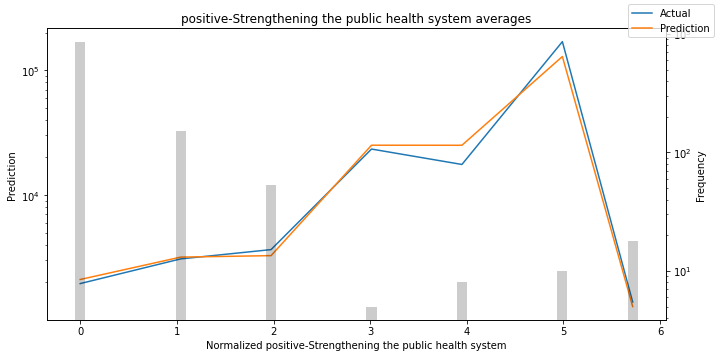

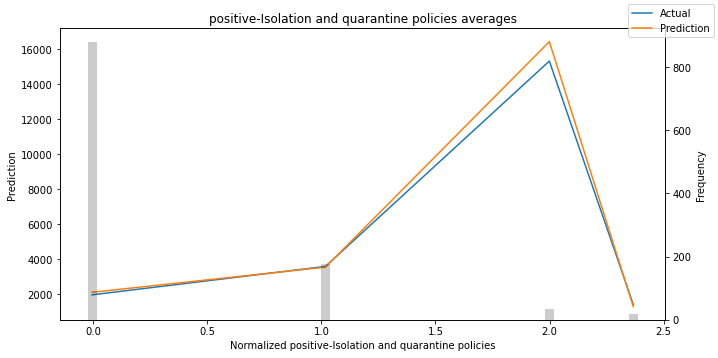

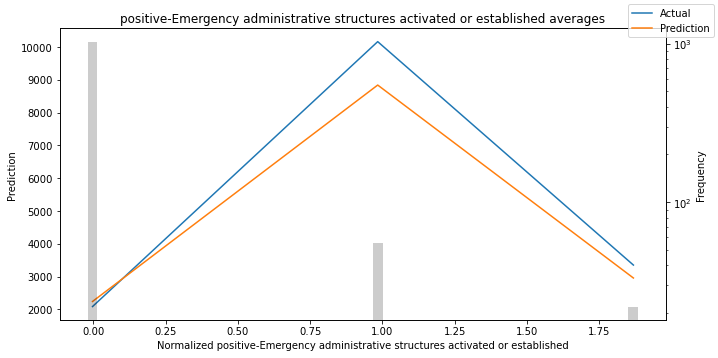

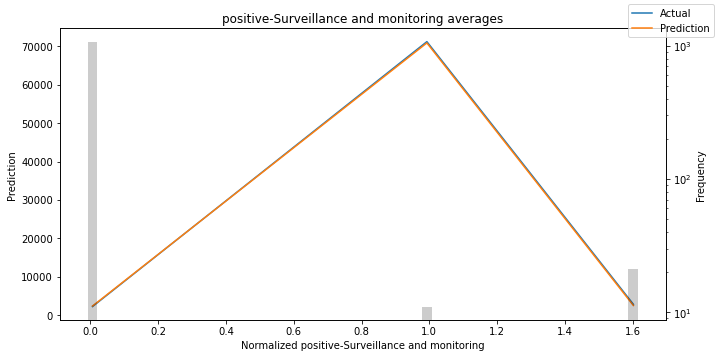

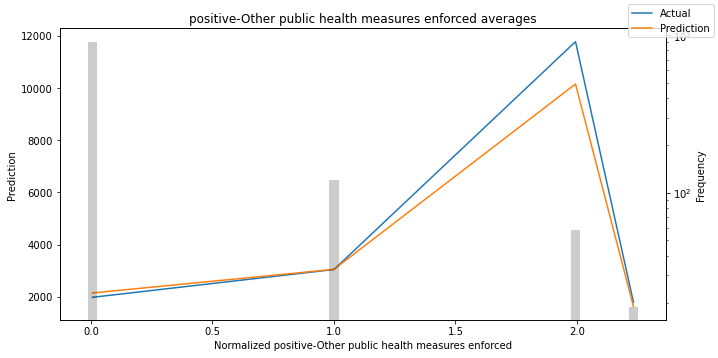

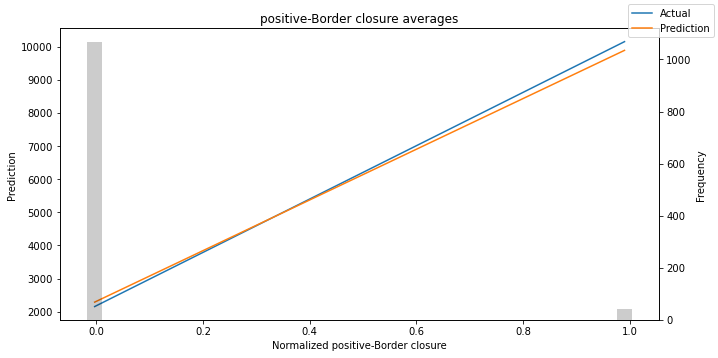

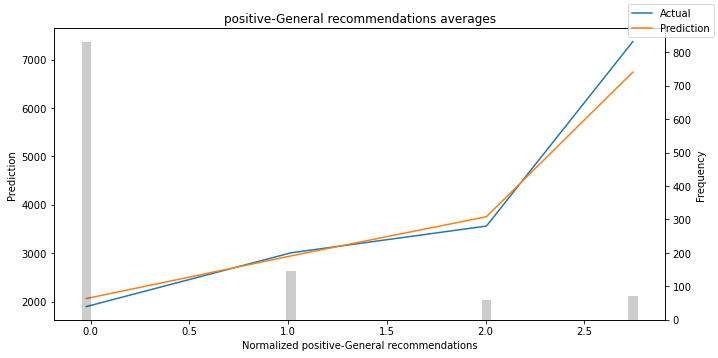

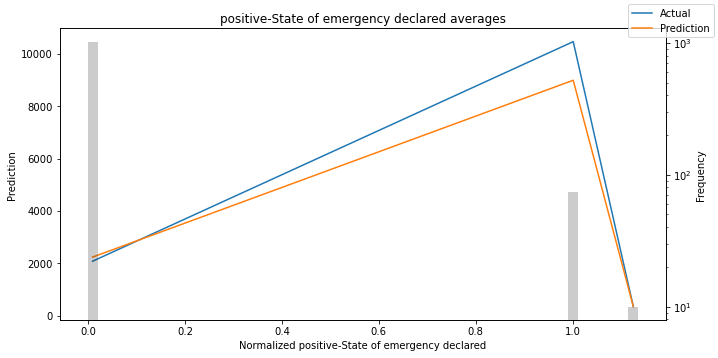

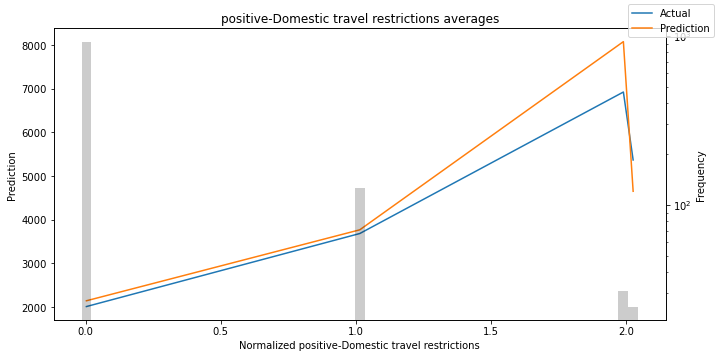

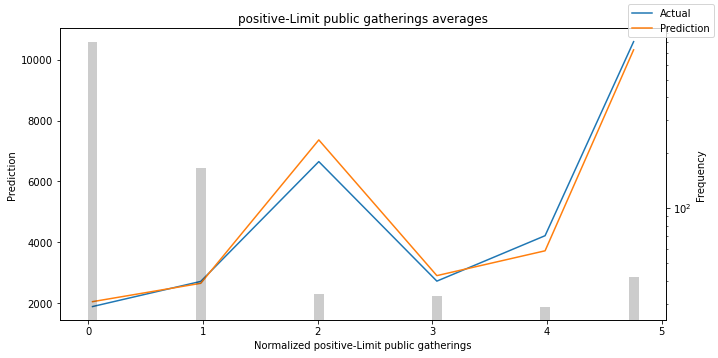

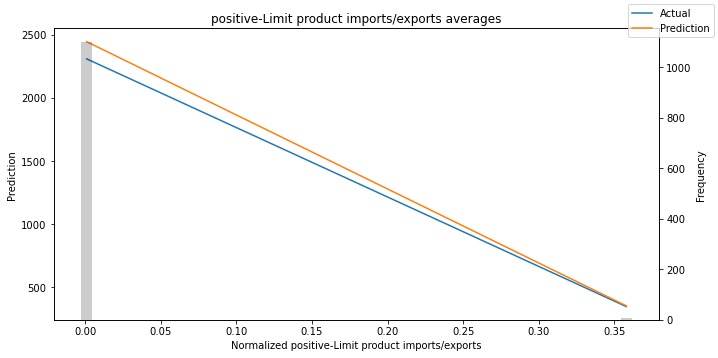

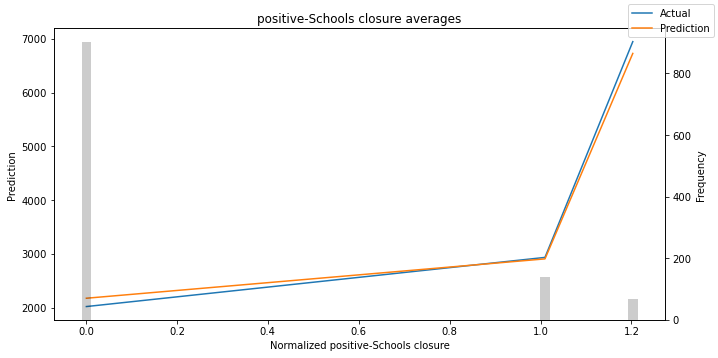

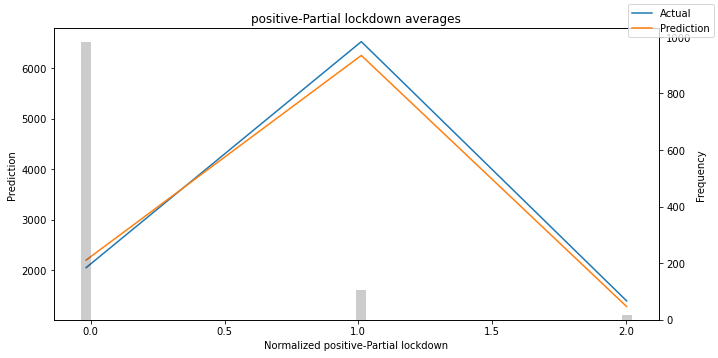

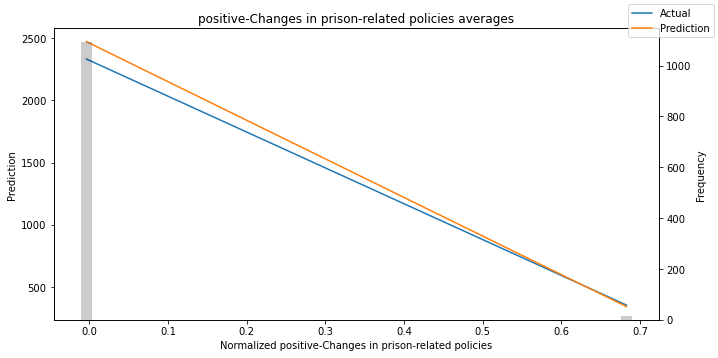

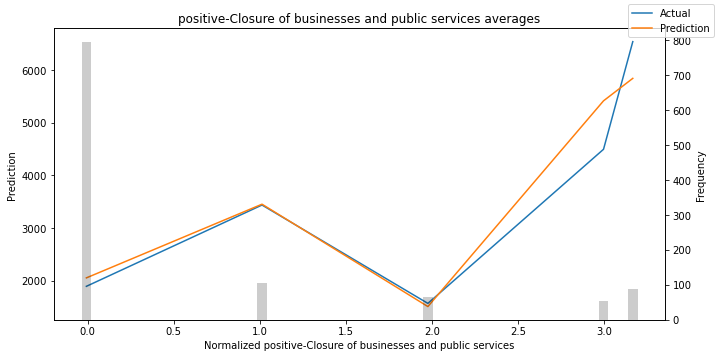

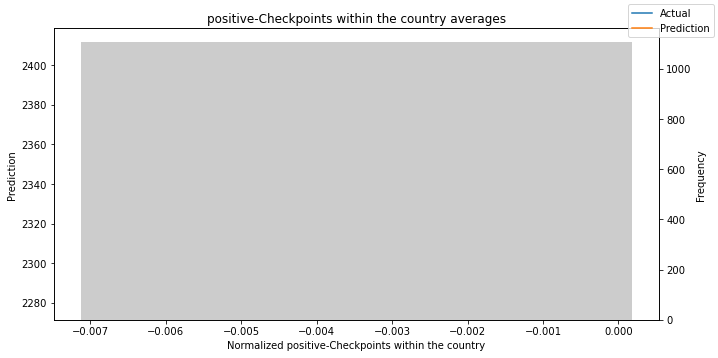

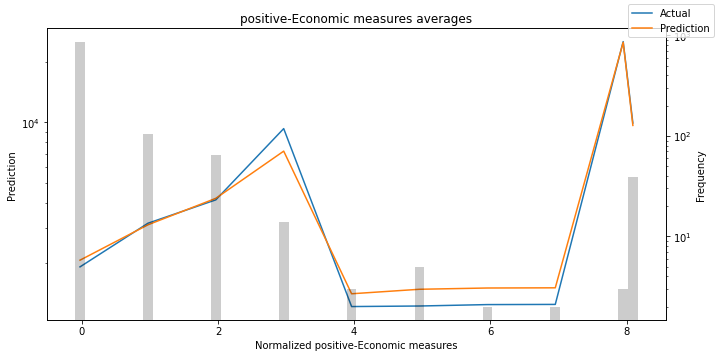

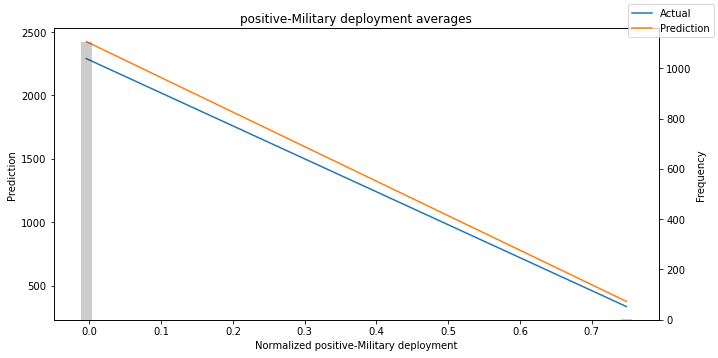

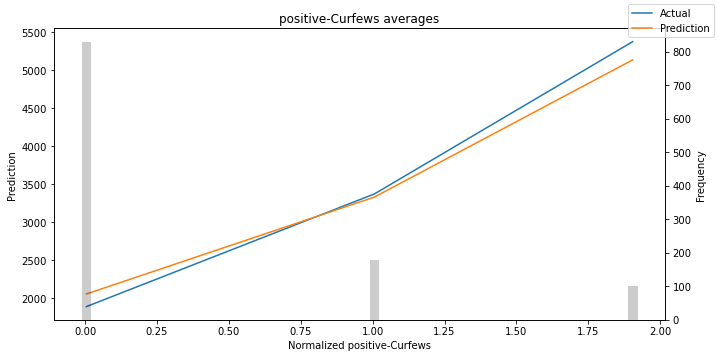

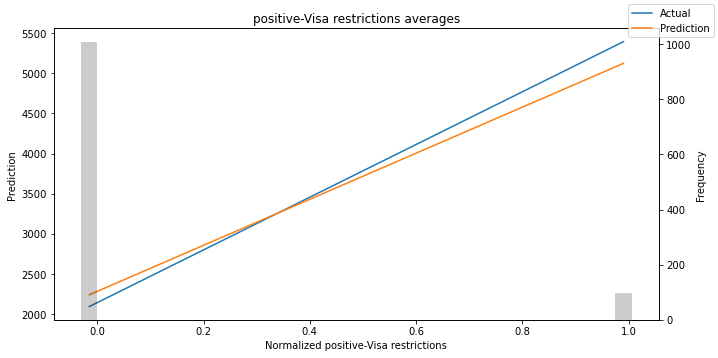

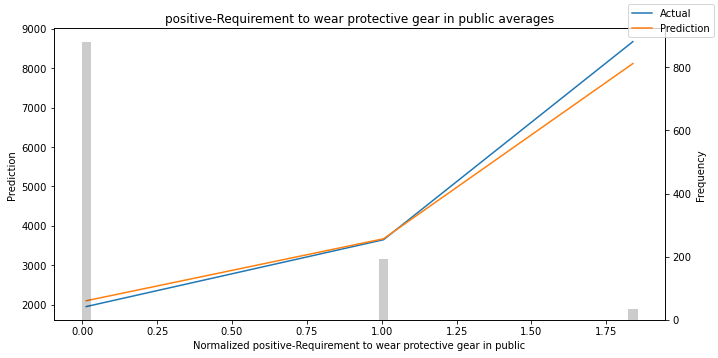

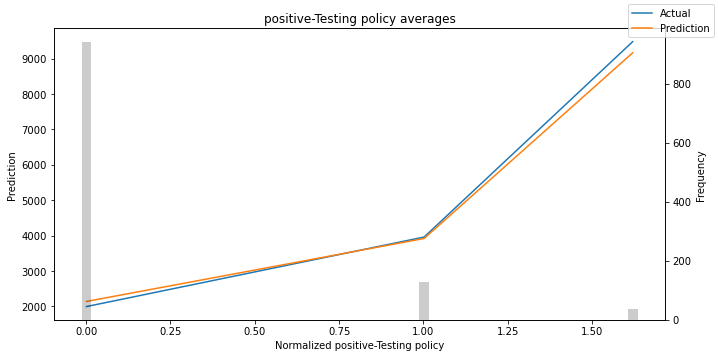

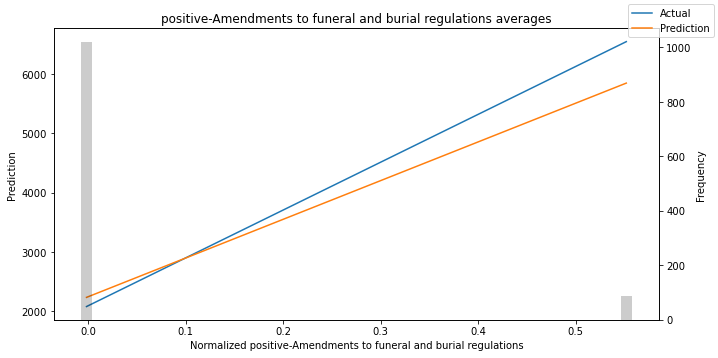

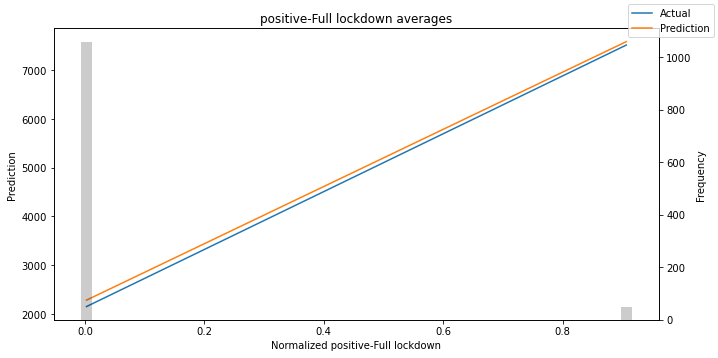

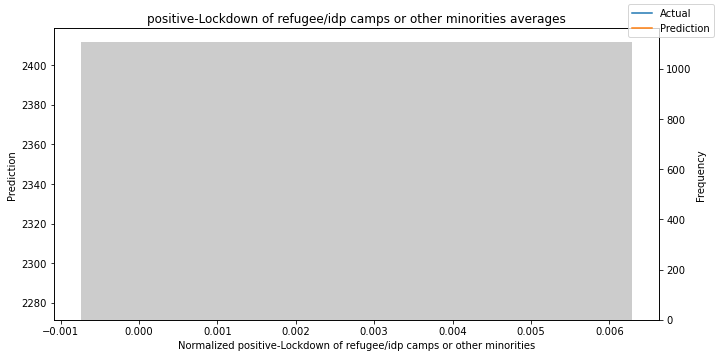

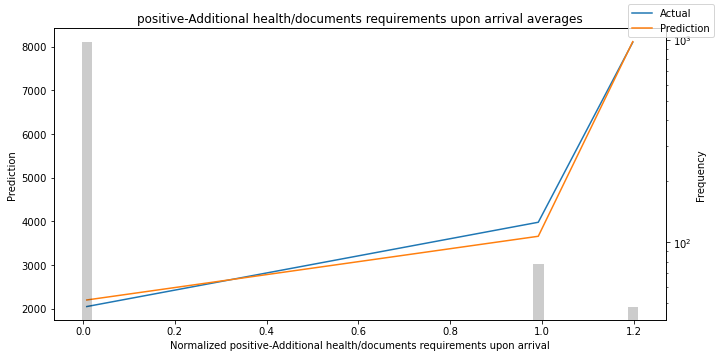

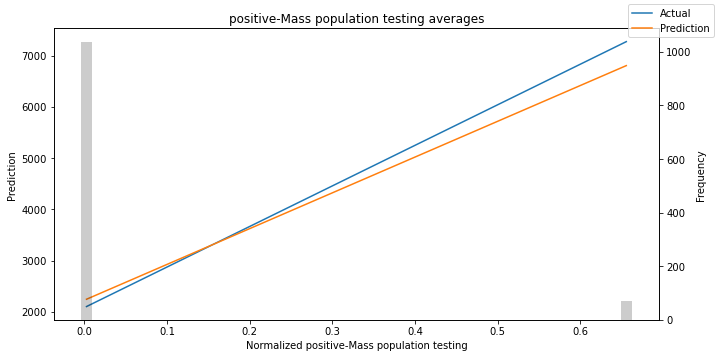

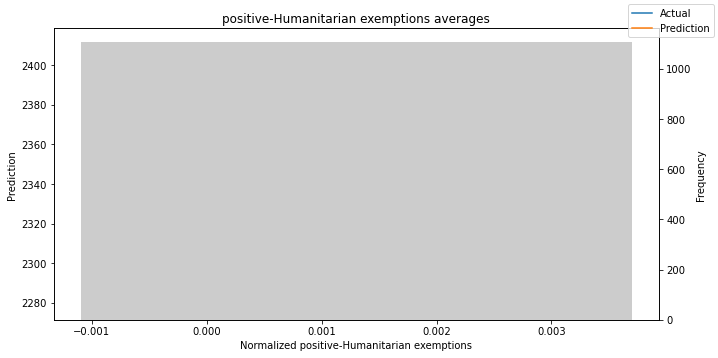

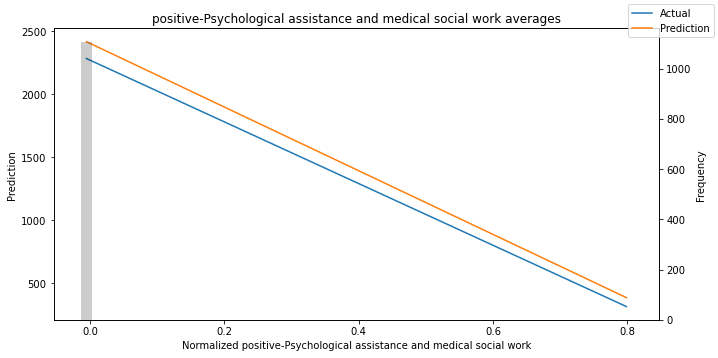

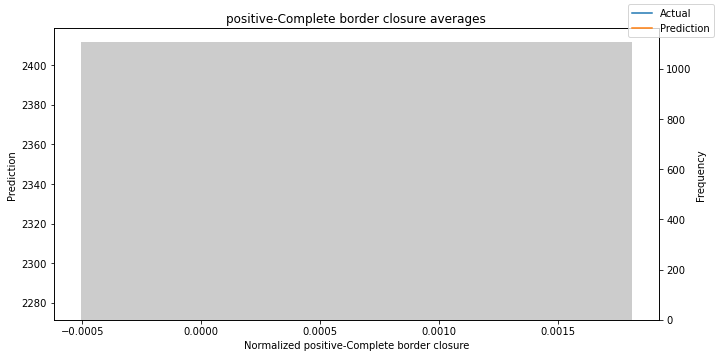

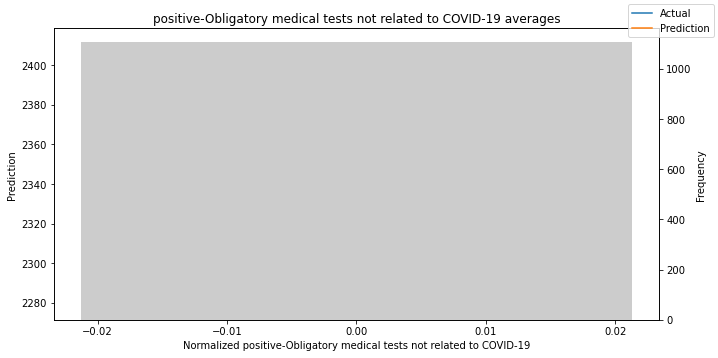

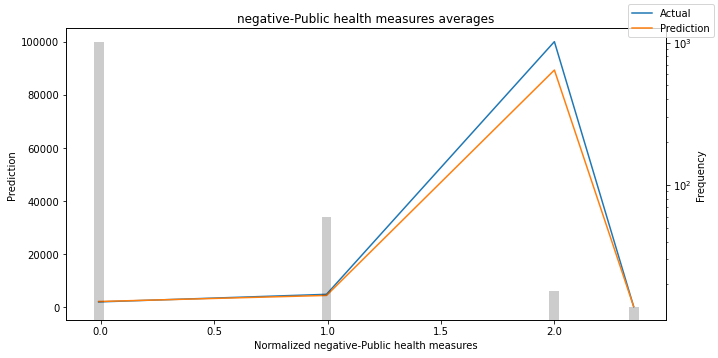

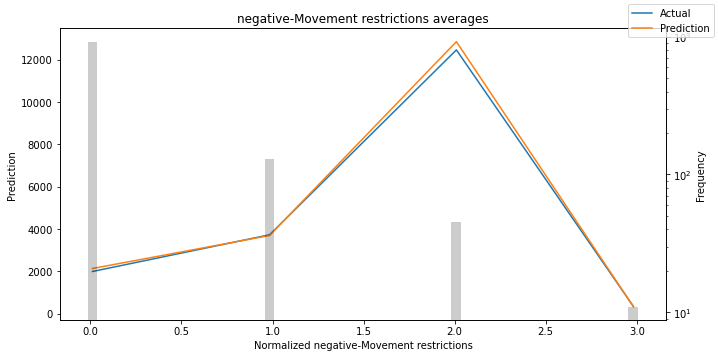

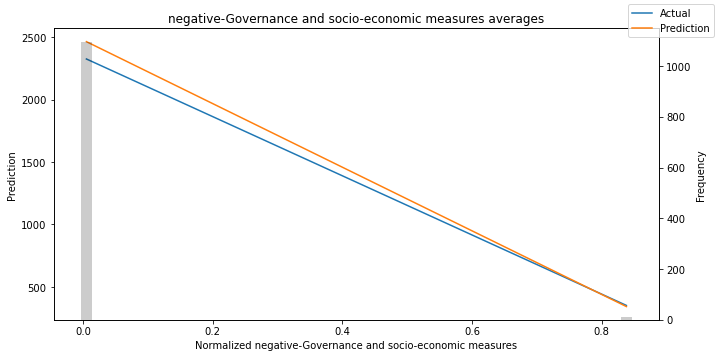

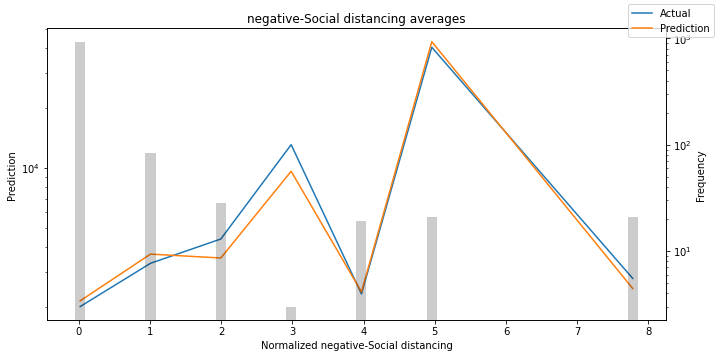

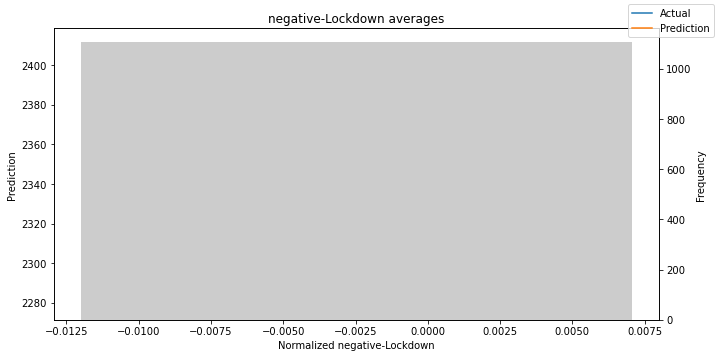

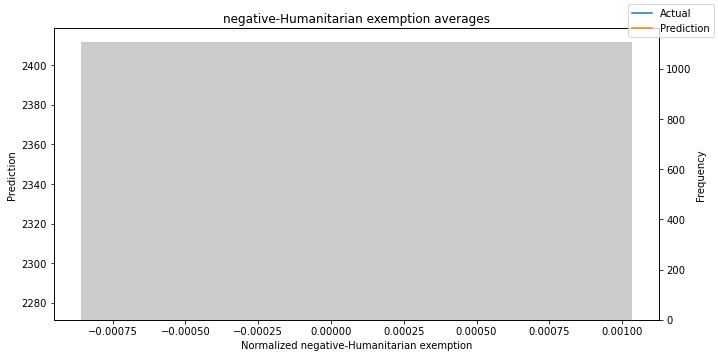

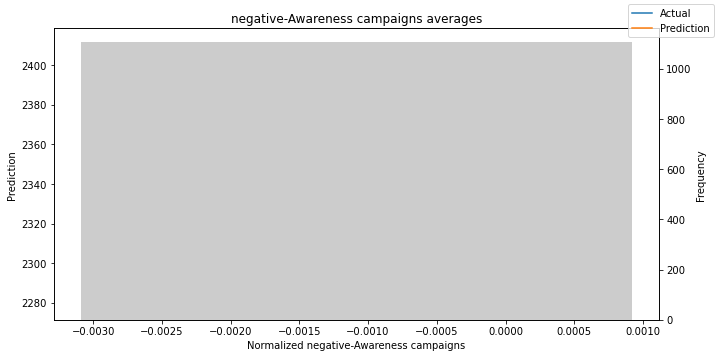

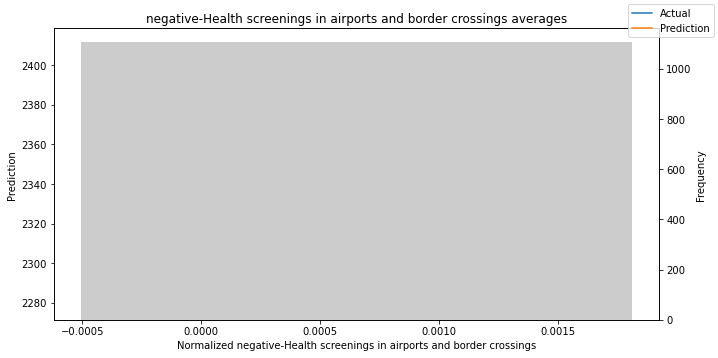

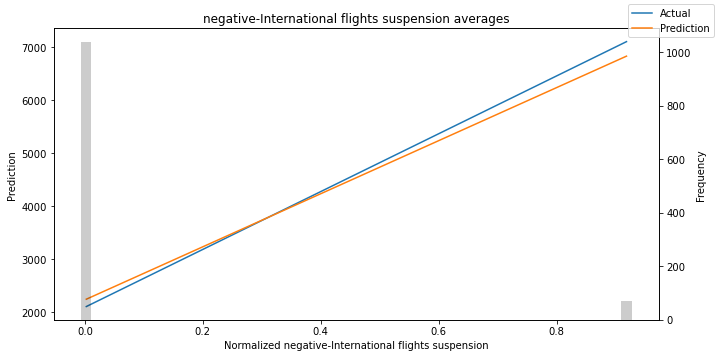

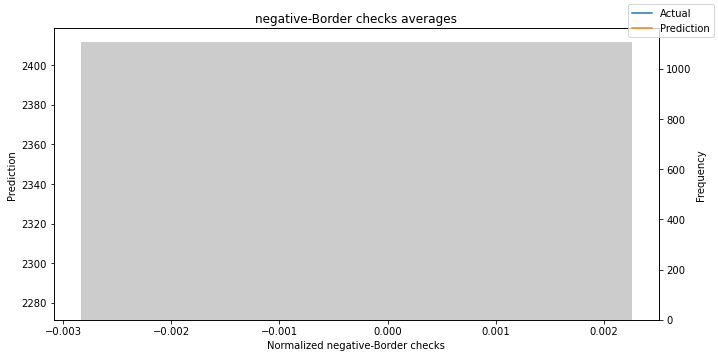

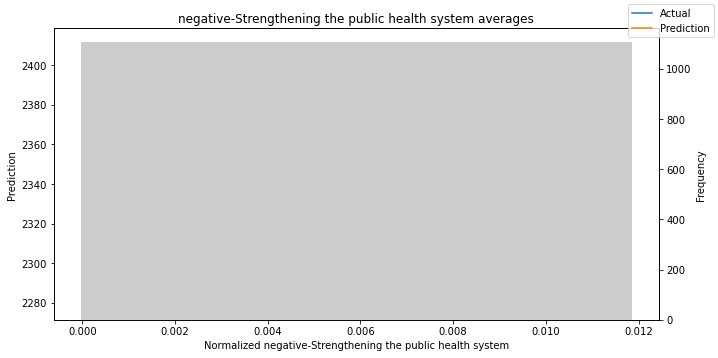

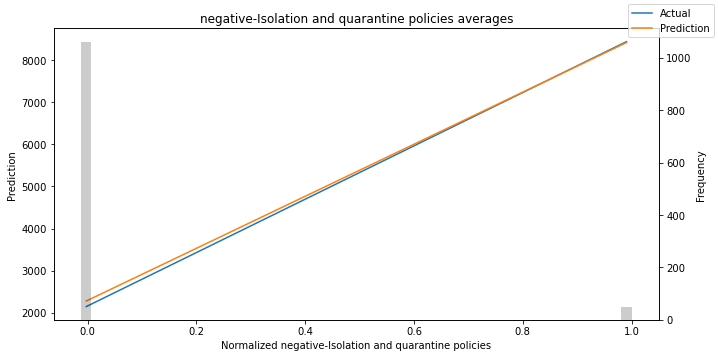

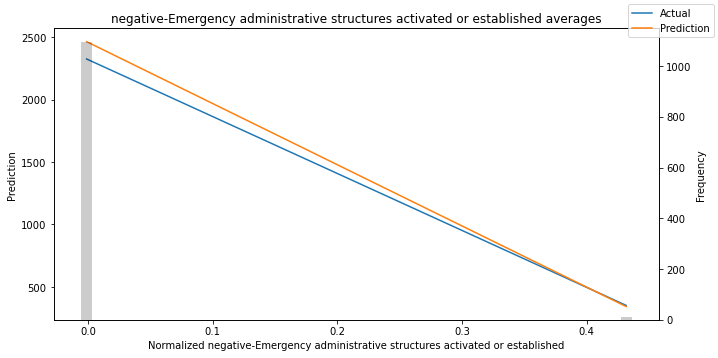

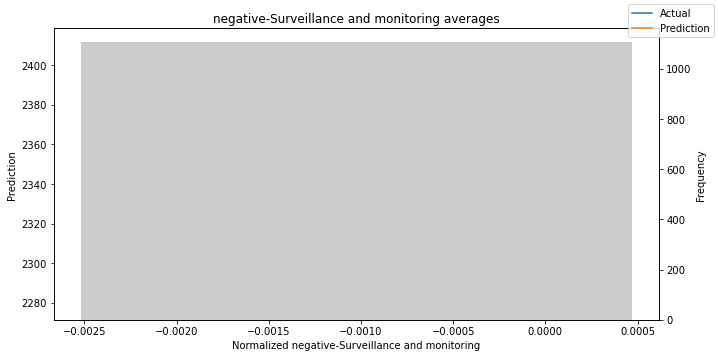

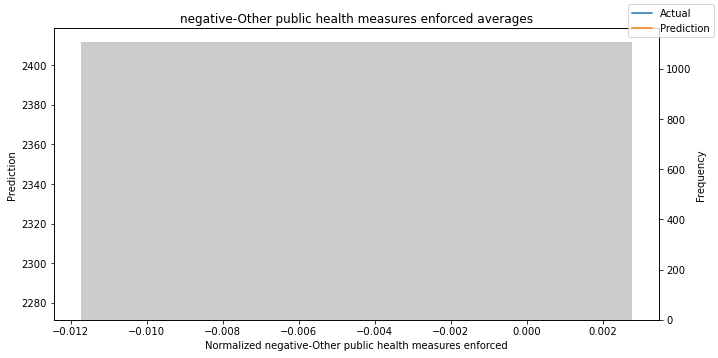

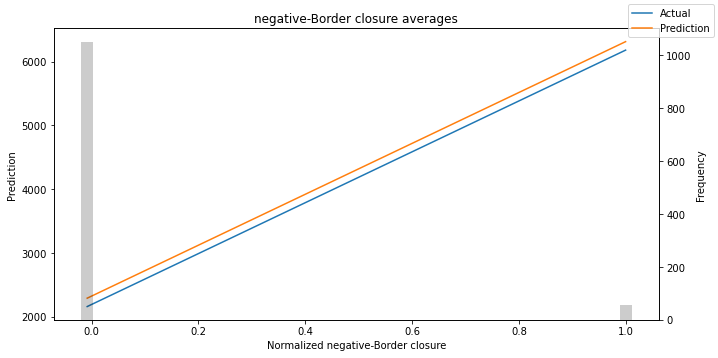

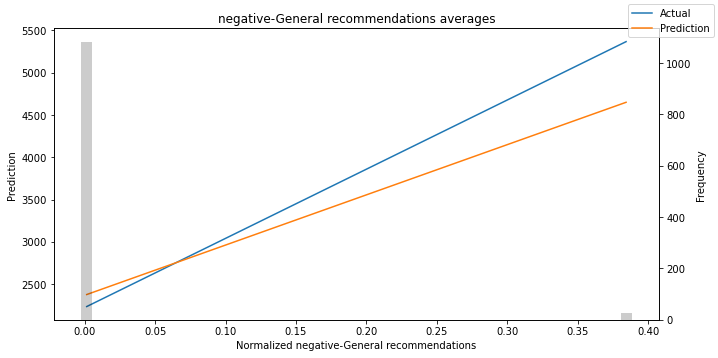

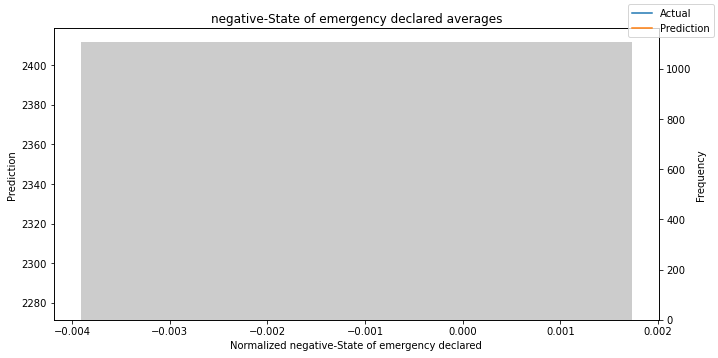

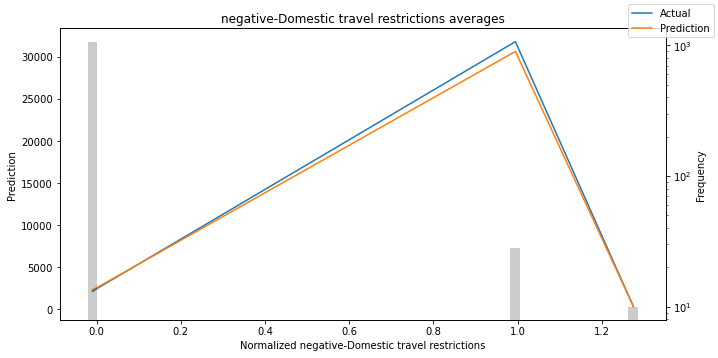

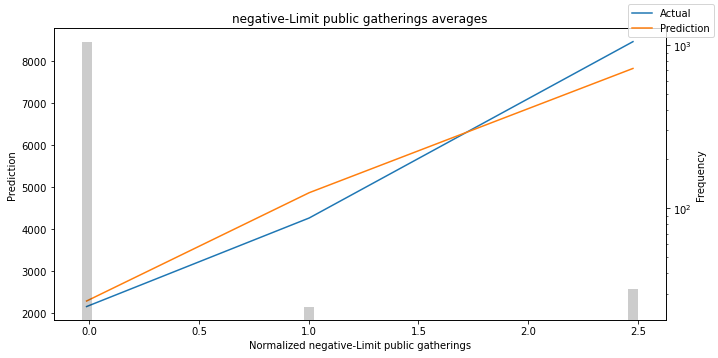

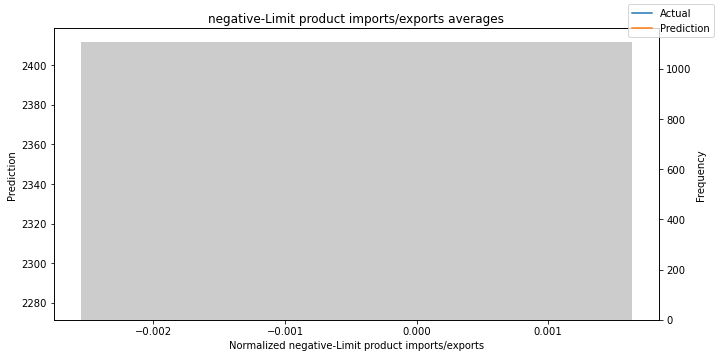

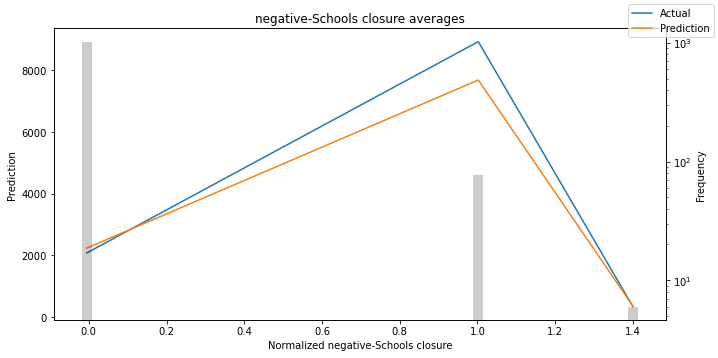

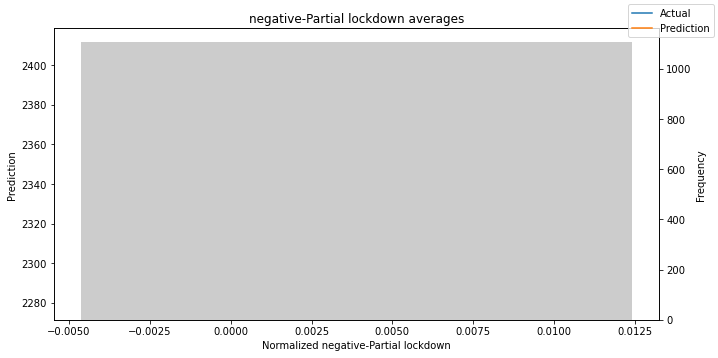

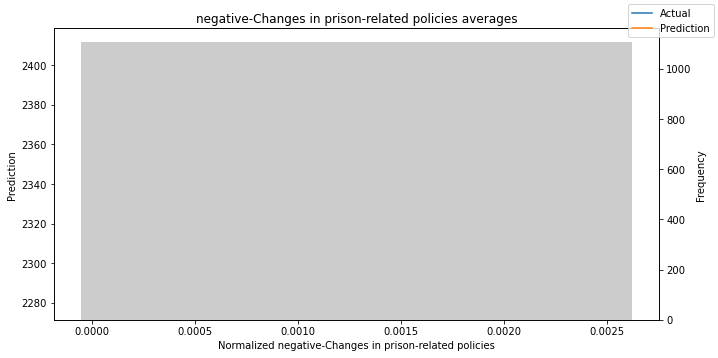

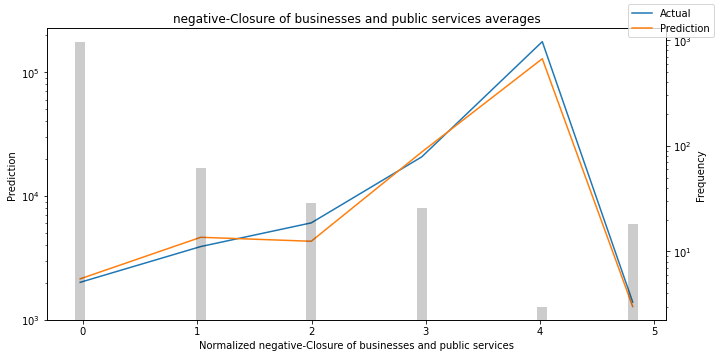

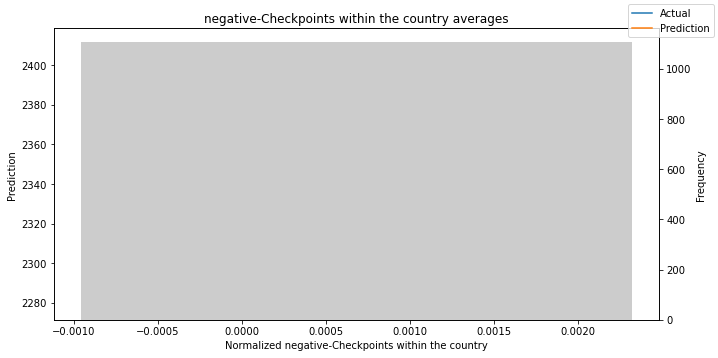

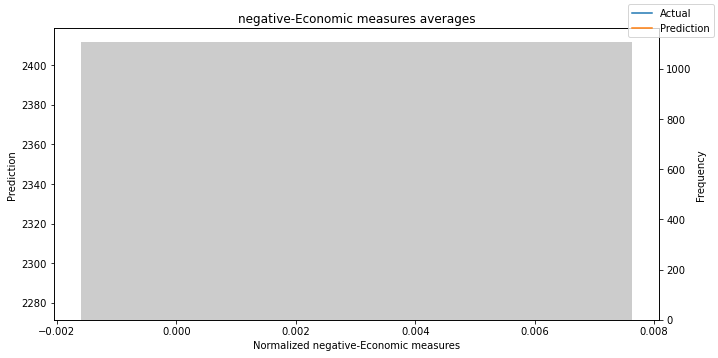

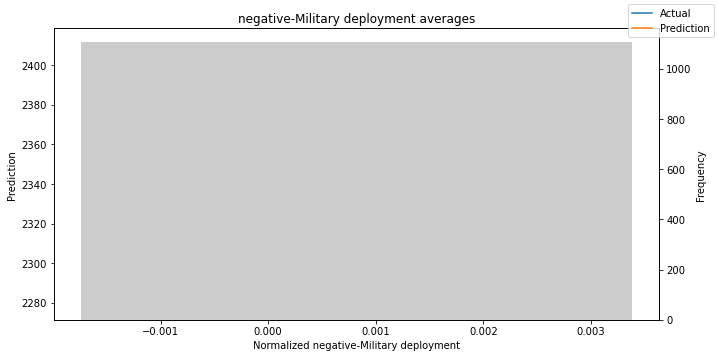

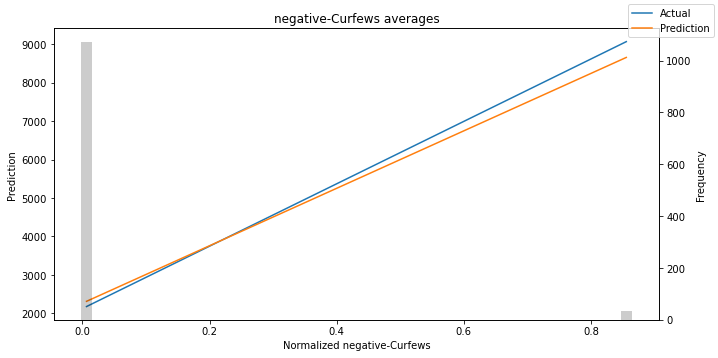

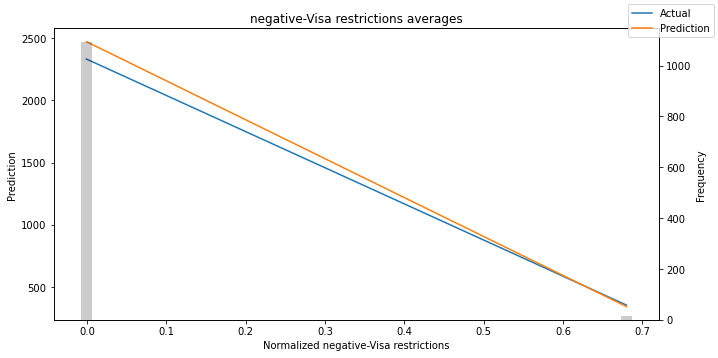

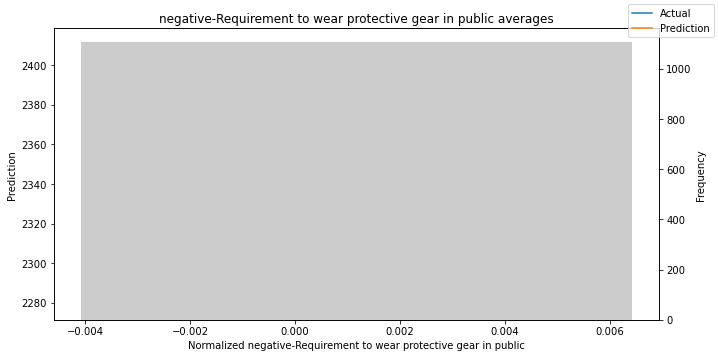

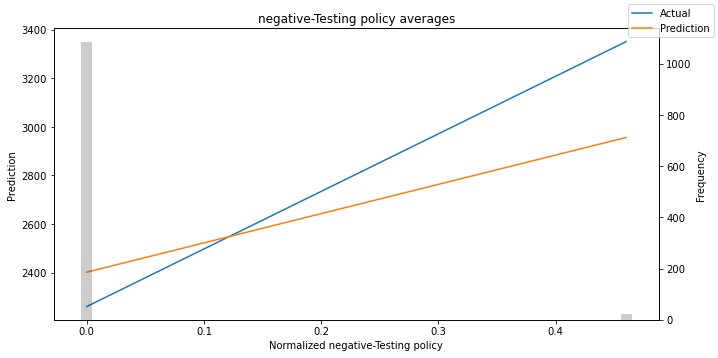

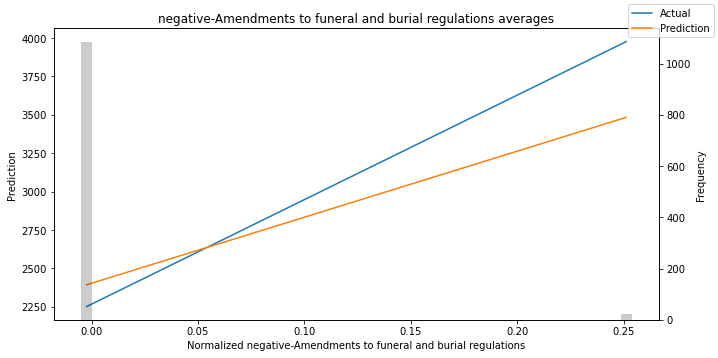

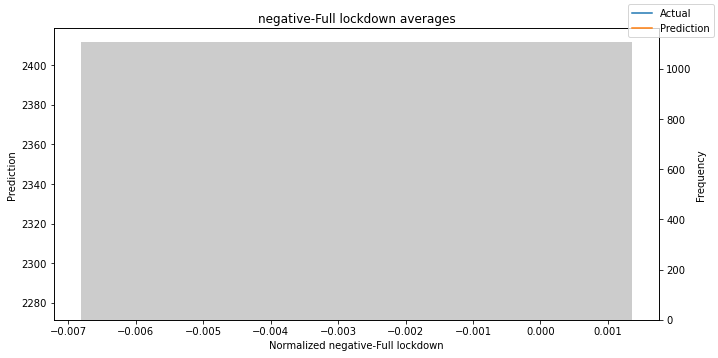

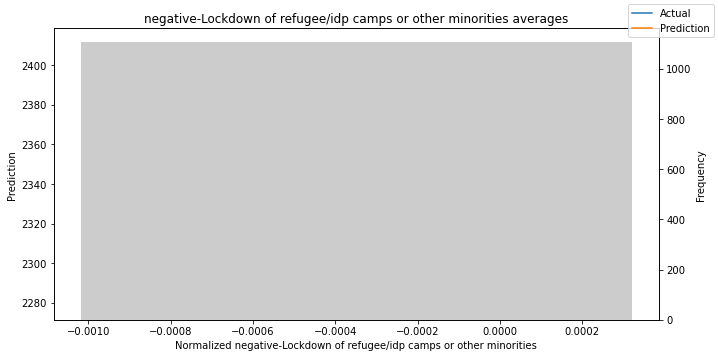

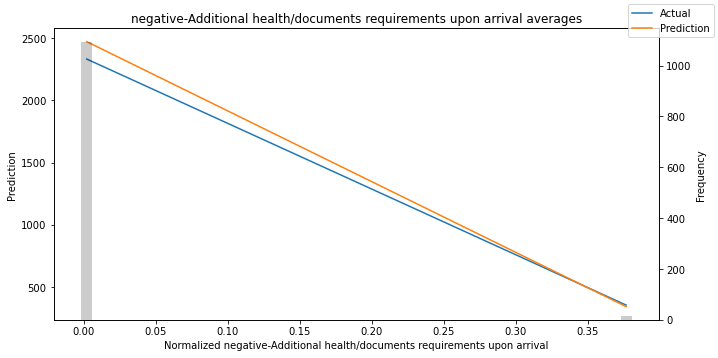

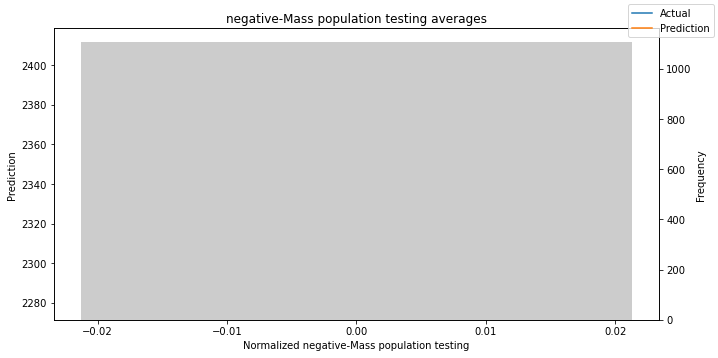

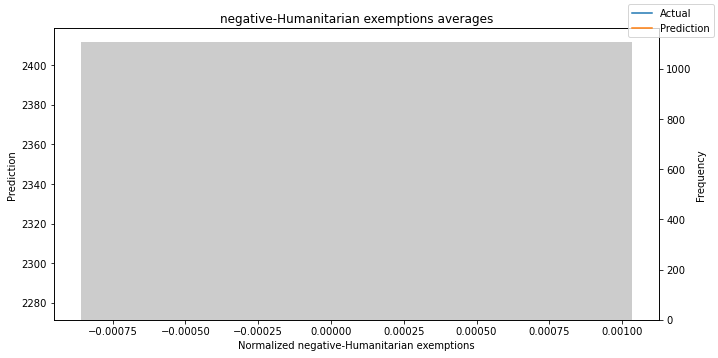

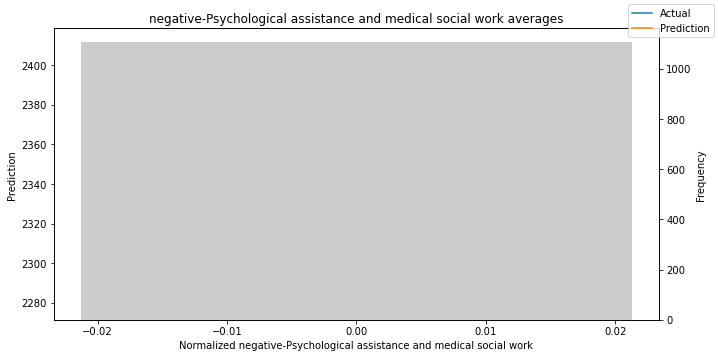

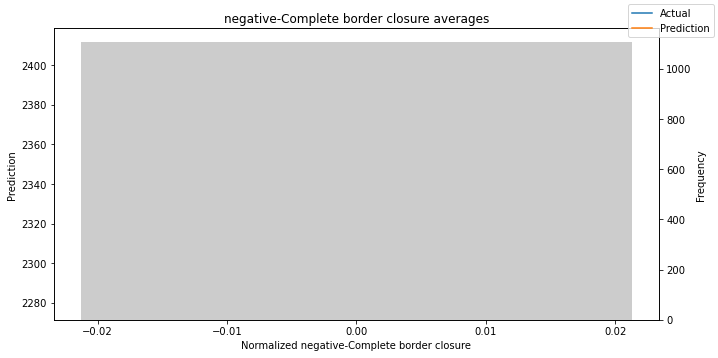

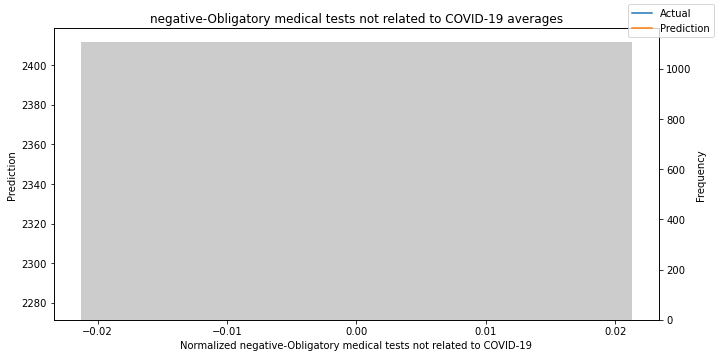

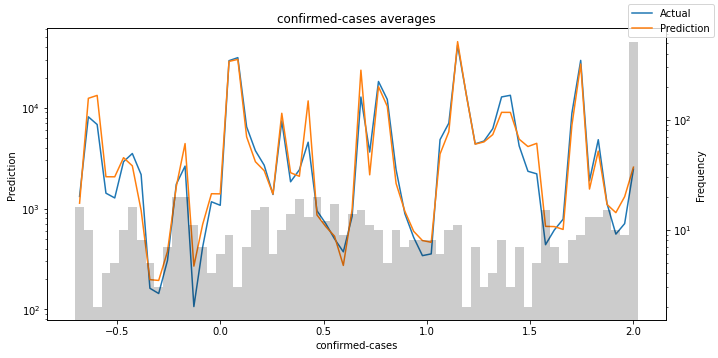

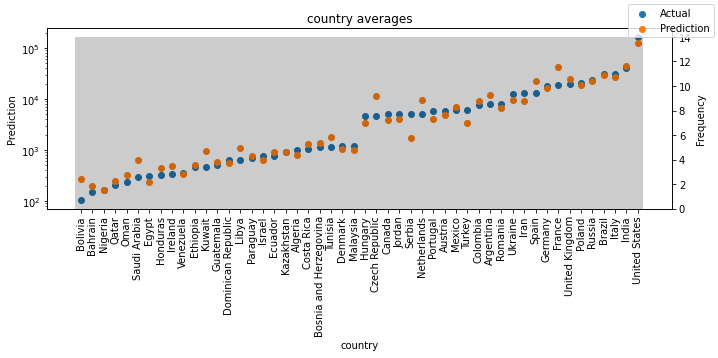

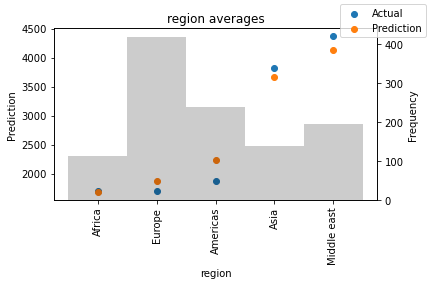

In [106]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);


{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x2394 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

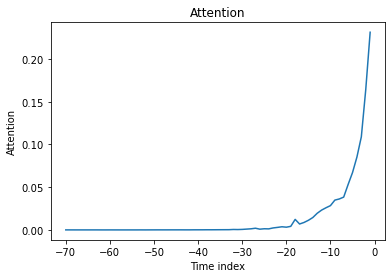

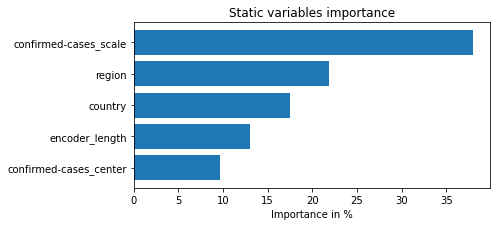

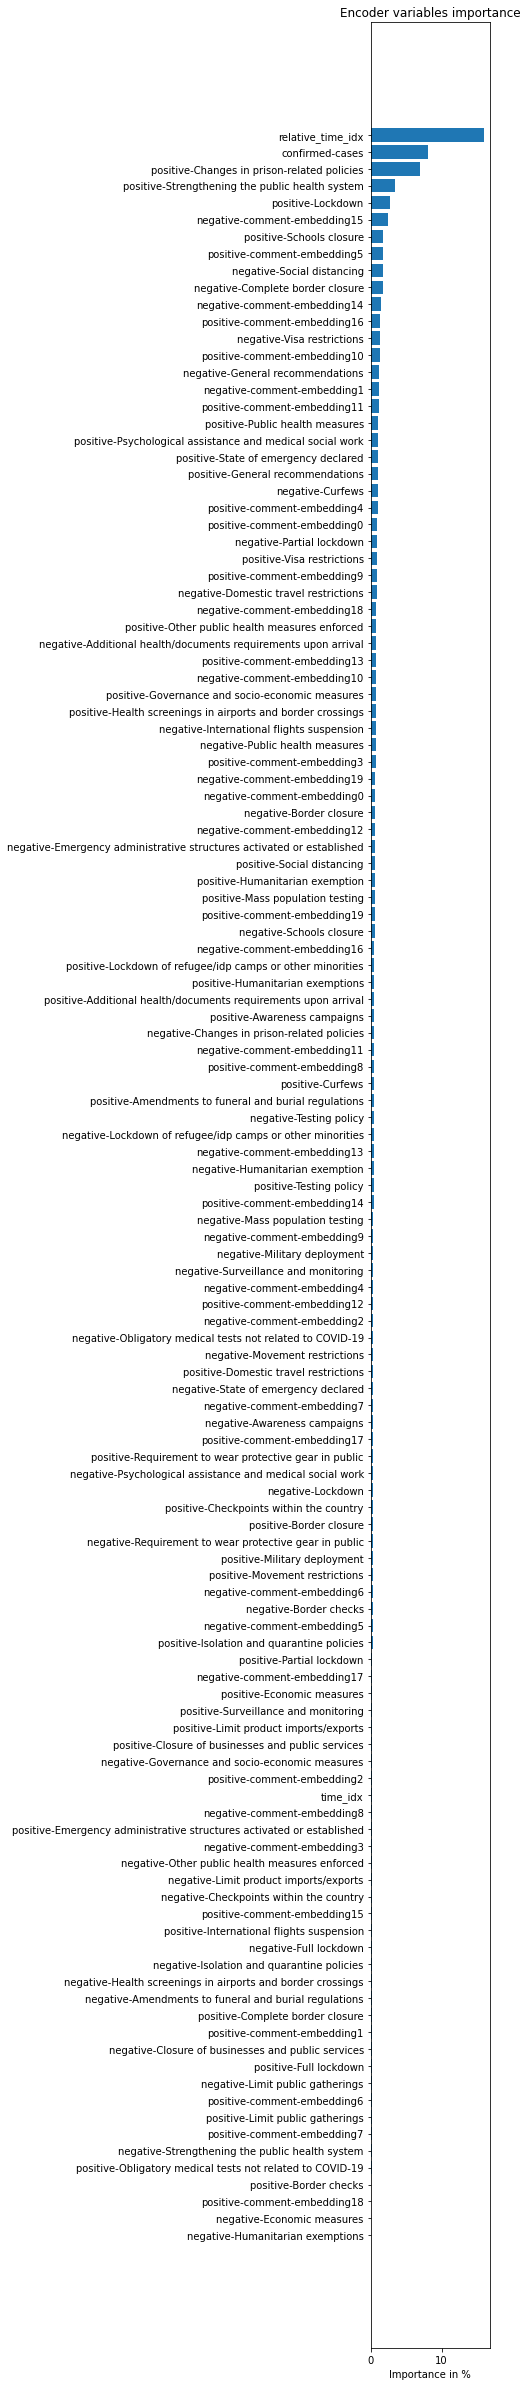

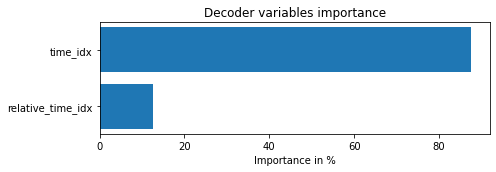

In [152]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [347]:
# predictions = best_tft.predict(val_dataloader)
predictions.shape

torch.Size([57, 15])

In [349]:
actuals.shape

torch.Size([57, 15])

In [350]:
len(data.country.unique())

57